# EEG to ECG Reconstruction


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale
from lib.gpr_utils import train_pulse
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from lib.utils import seed_everything
from lib.plot_utils import visualize_ecg_and_peaks, plot_augmentation_example, plot_train_hystory, visualize_predictions
from lib.dataset_utils import create_segments_sliding, create_training_segments_with_augmentation, create_segments_nonoverlapping, augment_segment
from lib.train_utils import evaluate_loader, subject_mae
from scipy.signal import butter, sosfiltfilt

seed_everything(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pytorch version: 2.5.1
Using device: cpu


In [3]:
# Configuration
A = 2              # Amplitude of the train pulses
width = 0.05       # Width of each pulse
tau = 5            # Lag (downsampling factor)
duration_sec = 10  # segment length

# Available subjects
subj_all = [29, 41, 30, 40, 23, 27, 28, 39]
test_subj = subj_all[0]
val_subj = subj_all[1]
train_subjects = [s for s in subj_all if s not in (test_subj, val_subj)]

# Pulse type for ECG transformation Gaussian or Rectangular
impulse = "Gaussian"

# Augmentation settings
use_augmentation = True
warp_factor_range = (0.85, 1.15)
aug_segment_duration = round(warp_factor_range[1] * duration_sec)       # seconds (larger than target to allow warping)
n_augmented_per_segment = 5

# Training settings
train_overlap = 0.9
batch_size = 16
learning_rate = 1e-3
epochs = 100
patience = 40

# Paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
parsed_path = os.path.join(cache_dir, "data_parsed_noSubsample.pkl")
preproc_path = os.path.join(cache_dir, "data_preprocessed_noSubsample.pkl")

# Heart-rate band filtering (~1 Hz)
use_hr_band_filter = True
lowcut=5
highcut=16

# Use only the first N seconds of each subject (after downsampling)
dataset_max_seconds = 120

## Load, Parse and Preprocess

Loaded parsed and preprocess data from cache


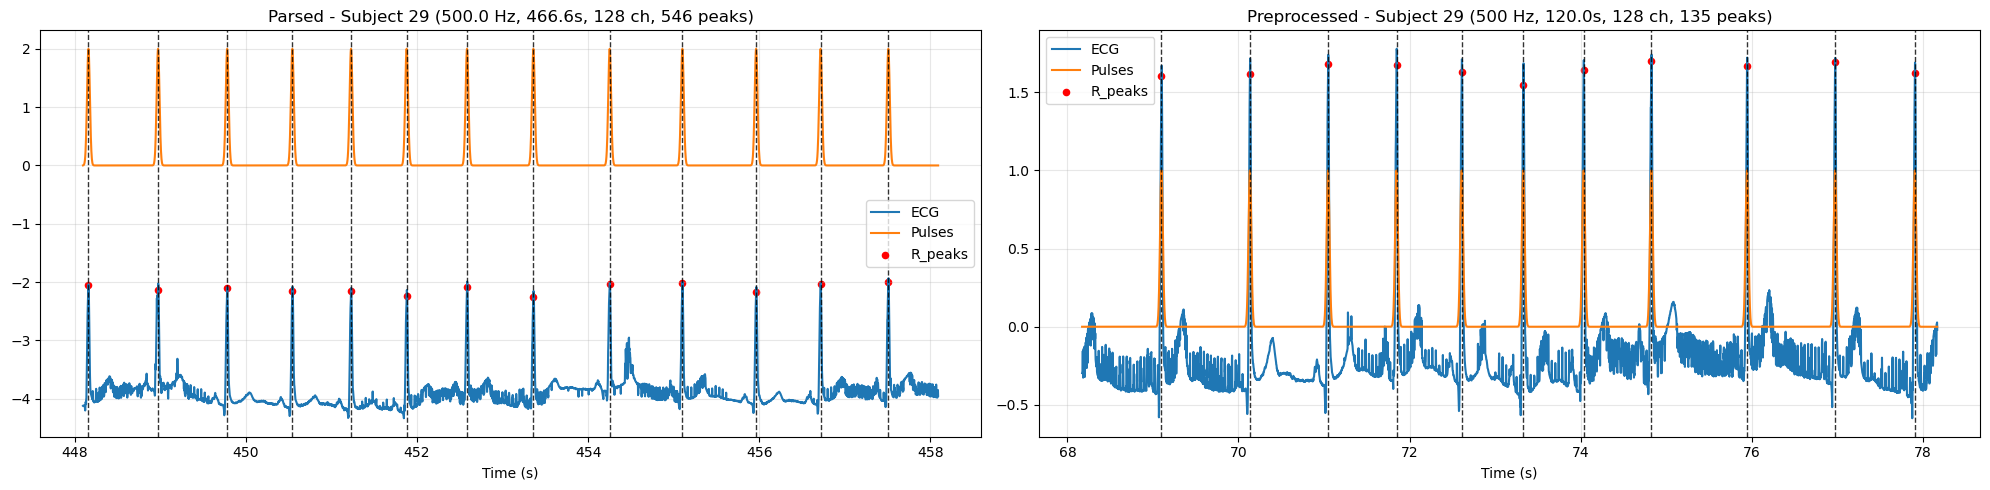

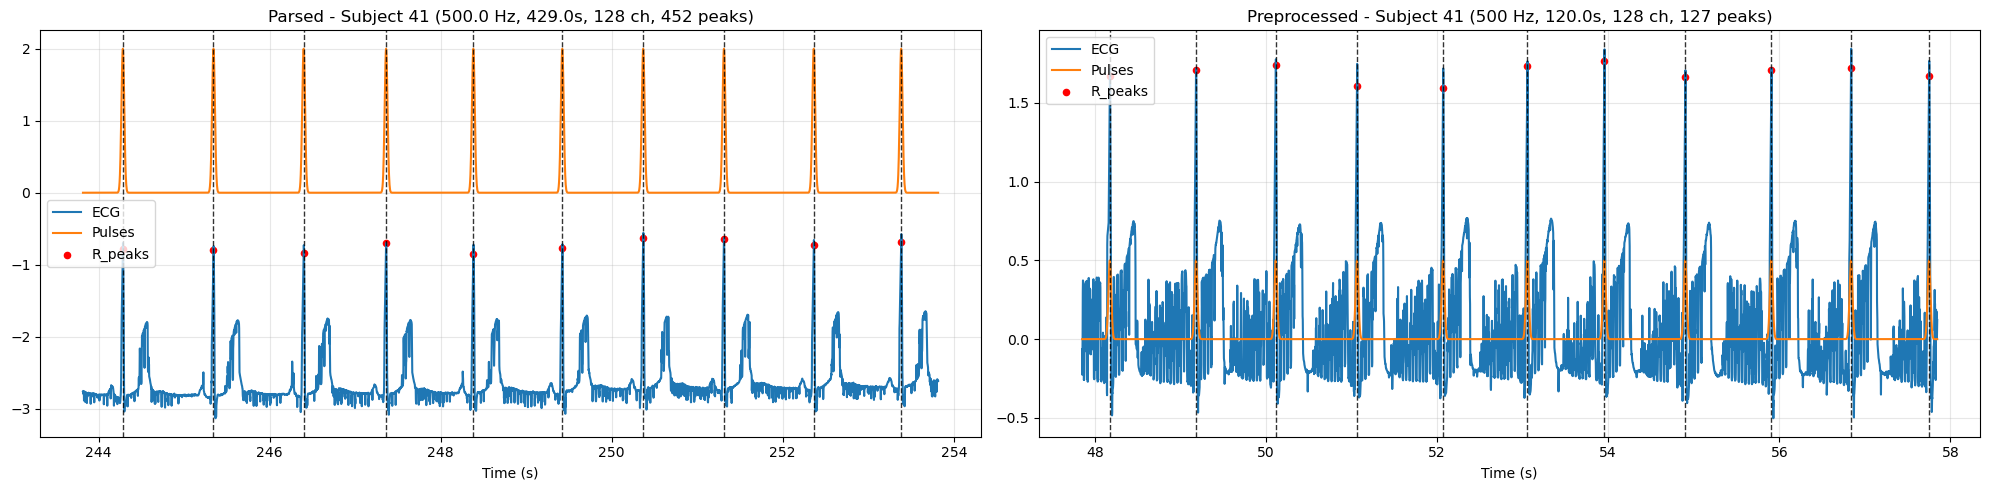

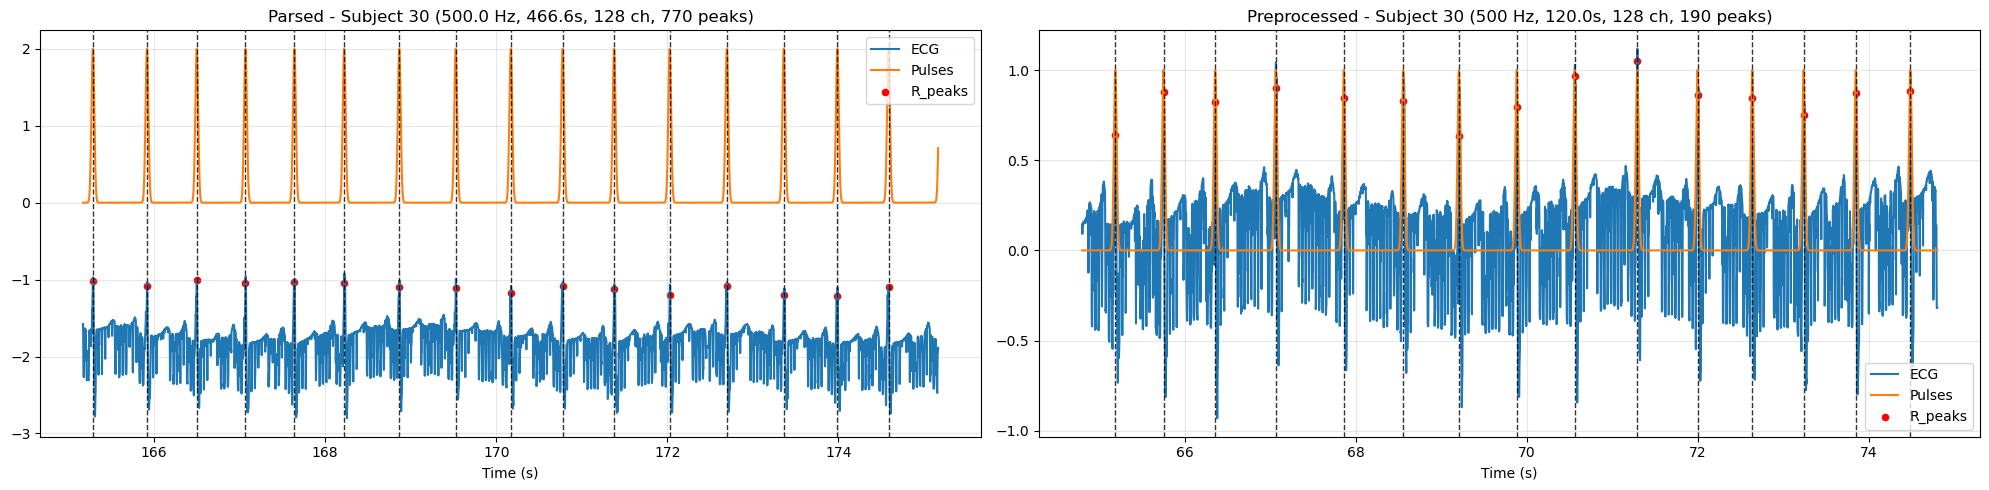

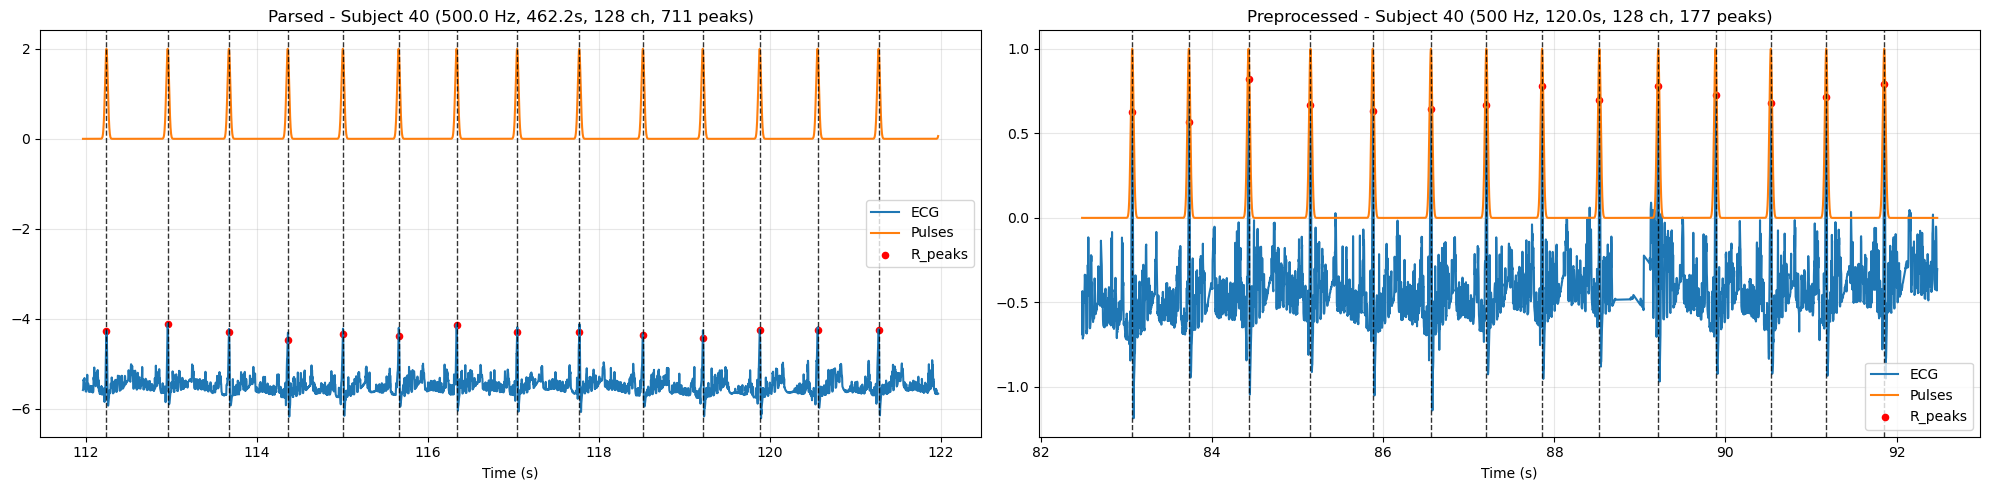

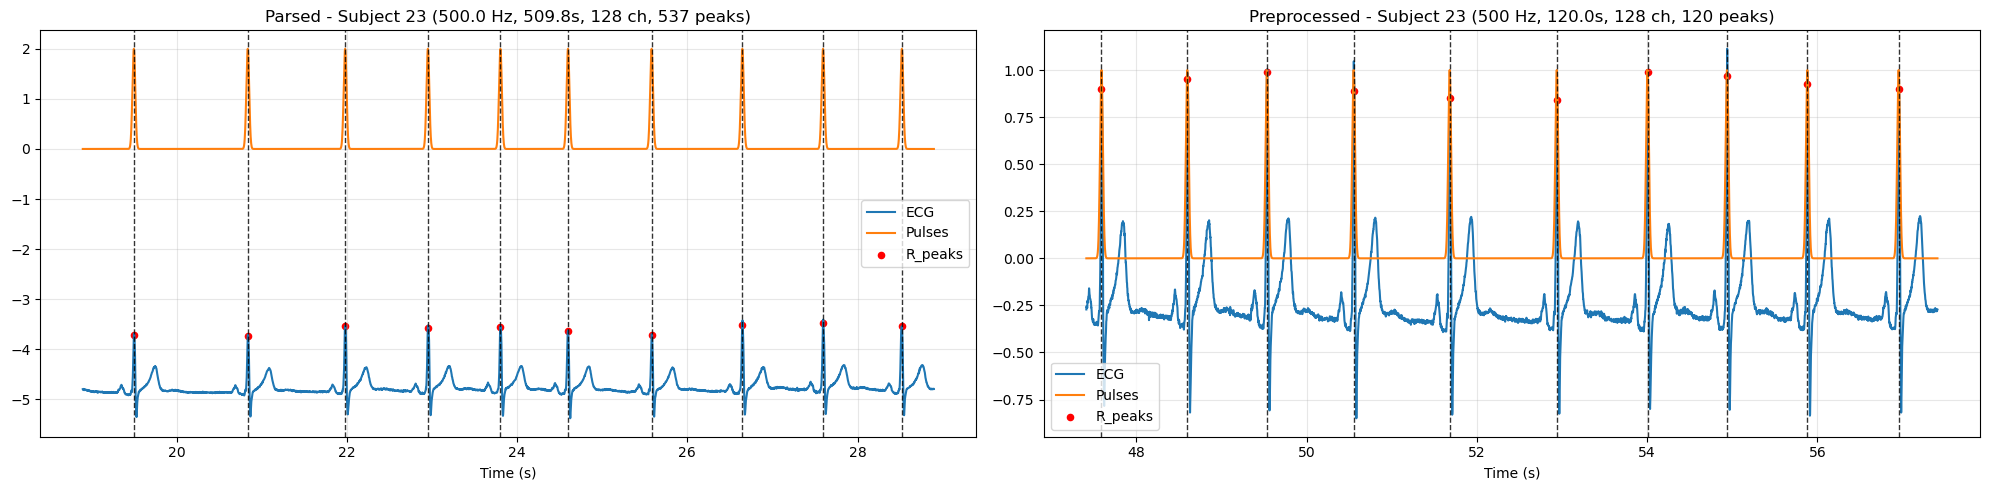

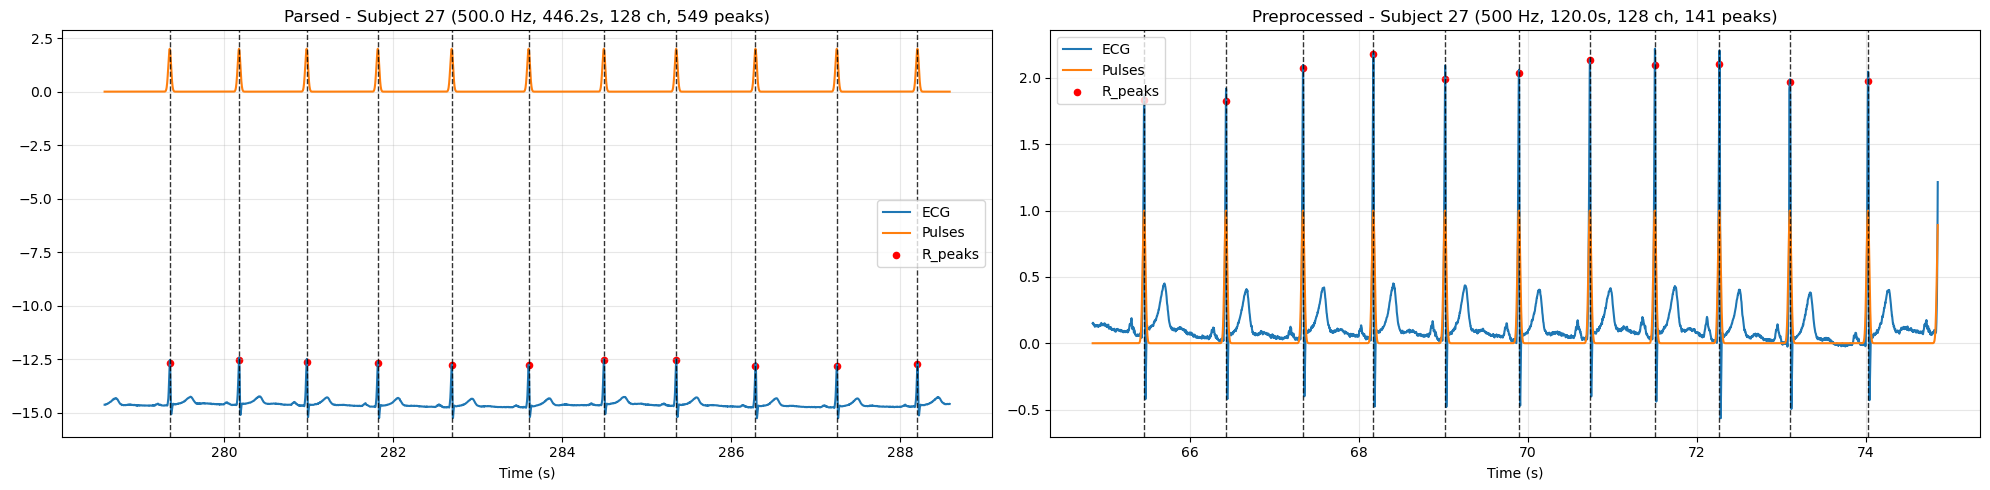

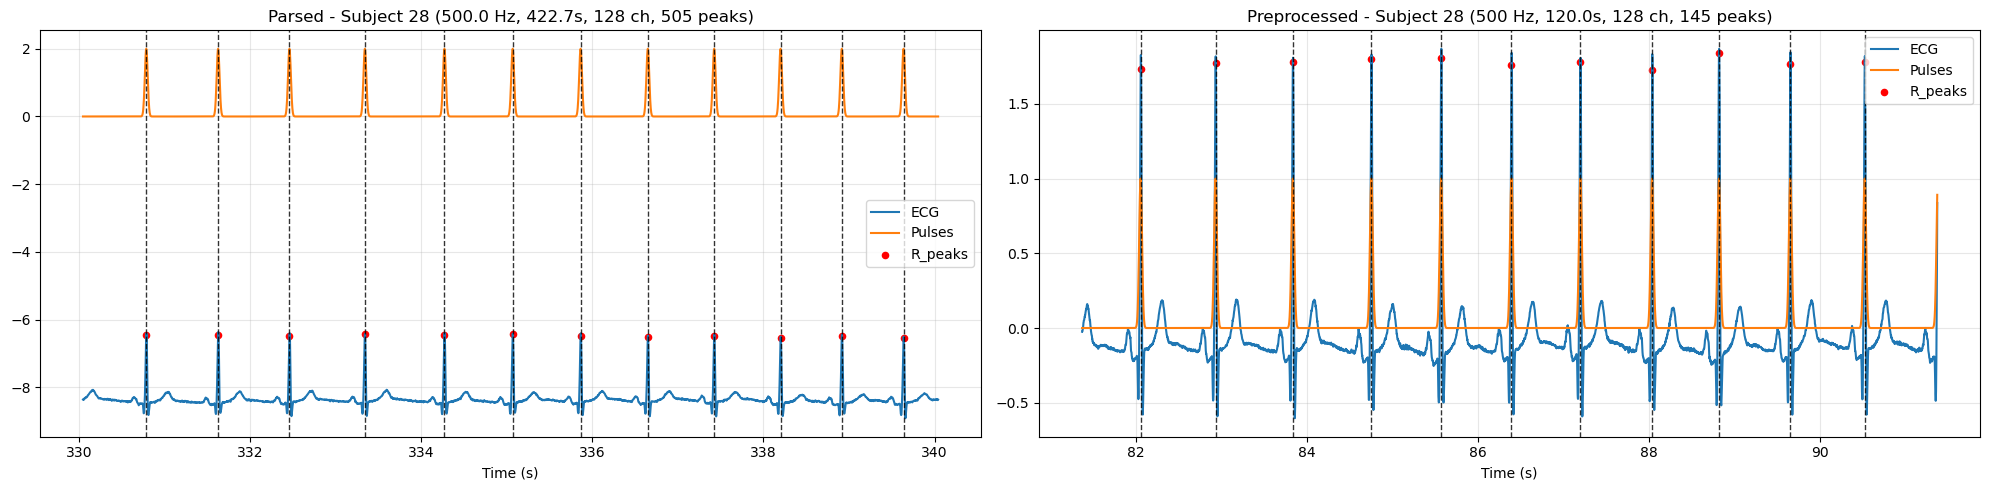

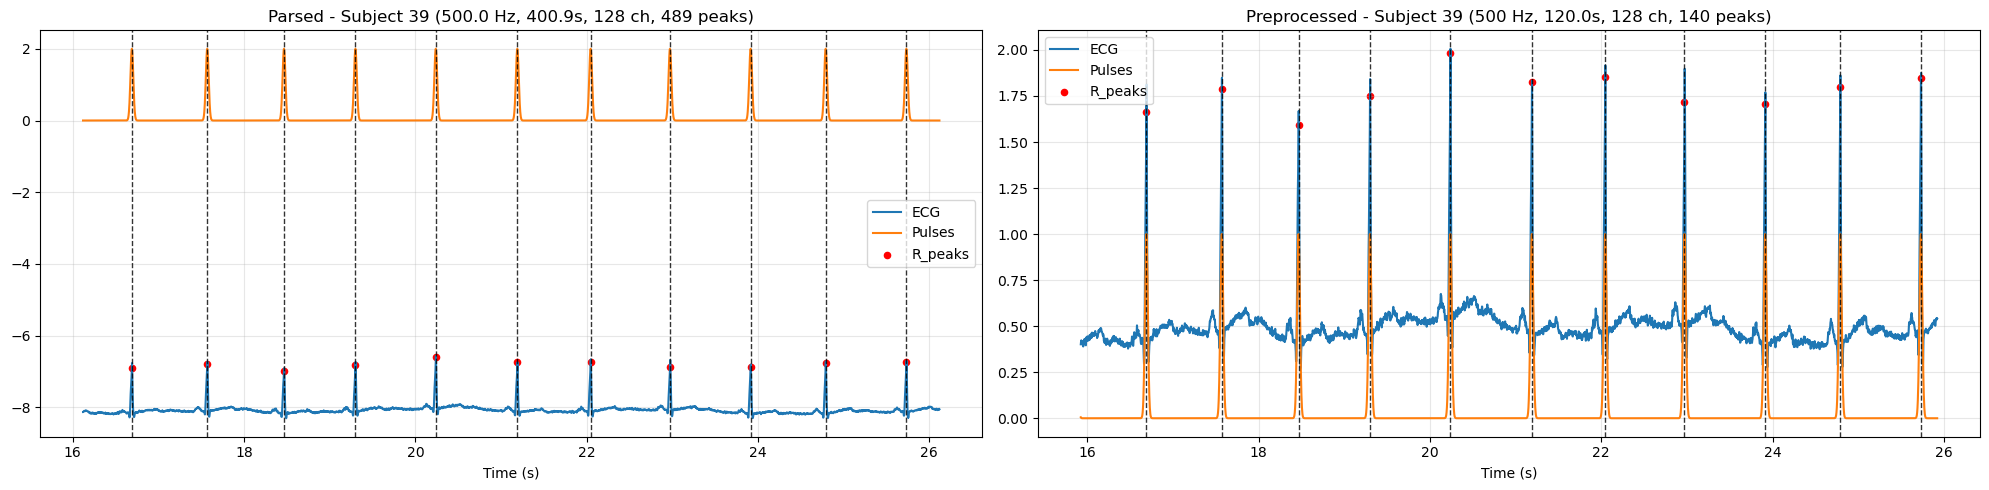

In [4]:
def load_subject_data(subj_id, A, width, impulse):
    """Load and parse data for a single subject."""
    # Load preprocessed EEG
    data = loadmat(f'Signals/P0{subj_id:02d}_prepro.mat')
    EEG_prepro = data['EEG_prepro']
    Y_prepro = EEG_prepro['data'][0, 0].astype(float)
    freq_prepro = float(EEG_prepro['srate'][0, 0])

    # Load ECG
    ecg_data = loadmat(f'Signals/P0{subj_id:02d}.mat')
    t_prepro = ecg_data["t_int"].flatten()
    t_prepro = np.insert(t_prepro, 0, 0.0)

    R_peak = ecg_data['R_peak'].flatten() - 1
    ECG = ecg_data['ECG_i'].flatten()
    ECG = np.insert(ECG, len(ECG), ECG[-1])

    # Generate pulse train
    ECG_pulse = train_pulse(Y_prepro, R_peak, A, width, freq_prepro, impulse)

    return { 'ECG': ECG, 'ECG_pulse': ECG_pulse, 'R_peaks': R_peak, 'EEG': Y_prepro, 'time': t_prepro, 'freq': freq_prepro }


def bandpass_eeg(x, fs, lowcut=0.1, highcut=22.5, order=4):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=-1)


def preprocess_subject_data(subject_data, tau):
    """Normalize and downsample subject data."""
    ECG = subject_data['ECG'].copy() - np.mean(subject_data['ECG'])
    ECG = ECG[::tau]  # downsample

    ECG_pulse = minmax_scale(subject_data['ECG_pulse'].copy().reshape(1, -1), feature_range=(0, 1), axis=1).flatten()
    ECG_pulse = ECG_pulse[::tau]

    EEG = minmax_scale(subject_data['EEG'].copy(), feature_range=(0, 1), axis=1)
    EEG = EEG - np.mean(EEG, axis=1, keepdims=True)  # Subtract per channel mean

    # Compute downsampled frequency
    freq = int(subject_data['freq'] / tau)

    # Downsample EEG
    EEG = EEG[:, ::tau]

    R_peaks = subject_data['R_peaks'].copy() // tau
    time = subject_data['time'].copy()[::tau]

    return {
        'ECG': ECG,
        'ECG_pulse': ECG_pulse,
        'R_peaks': R_peaks,
        'EEG': EEG,
        'time': time,
        'freq': freq
    }

# Load parsed data
if os.path.exists(parsed_path) and os.path.exists(preproc_path):
    with open(parsed_path, "rb") as f:
        data_parsed = pickle.load(f)
    with open(preproc_path, "rb") as f:
        data_preprocessed = pickle.load(f)
    print(f"Loaded parsed and preprocess data from cache")
else:
    print("Loading and parsing raw data...")
    data_parsed = {}
    data_preprocessed = {}
    for ss in subj_all:
        print(f"  Loading subject {ss}...")
        data_parsed[ss] = load_subject_data(ss, A, width, impulse)
        data_preprocessed[ss] = preprocess_subject_data(data_parsed[ss], tau)
    with open(parsed_path, "wb") as f:
        pickle.dump(data_parsed, f)
    print(f"Saved to {parsed_path}")
    with open(preproc_path, "wb") as f:
        pickle.dump(data_preprocessed, f)
    print(f"Saved to {preproc_path}")

# Apply HR band-pass AFTER loading (works with PKL cache)
if use_hr_band_filter:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        eeg_unfilt = np.asarray(data_preprocessed[ss]['EEG'], dtype=float)
        data_preprocessed[ss]['EEG_unfilt'] = eeg_unfilt
        data_preprocessed[ss]['EEG'] = bandpass_eeg(eeg_unfilt, fs_ds, lowcut=lowcut, highcut=highcut)

# Trim all signals to the first dataset_max_seconds seconds
if dataset_max_seconds is not None:
    for ss in subj_all:
        fs_ds = int(data_preprocessed[ss]['freq'])
        max_samples = int(dataset_max_seconds * fs_ds)
        # Bound against available length
        T = data_preprocessed[ss]['EEG'].shape[1]
        max_samples = min(max_samples, T)

        # Slice time-series
        data_preprocessed[ss]['EEG'] = data_preprocessed[ss]['EEG'][:, :max_samples]
        if 'EEG_unfilt' in data_preprocessed[ss]:
            data_preprocessed[ss]['EEG_unfilt'] = data_preprocessed[ss]['EEG_unfilt'][:, :max_samples]
        data_preprocessed[ss]['ECG'] = data_preprocessed[ss]['ECG'][:max_samples]
        data_preprocessed[ss]['ECG_pulse'] = data_preprocessed[ss]['ECG_pulse'][:max_samples]
        data_preprocessed[ss]['time'] = data_preprocessed[ss]['time'][:max_samples]

        # Keep R-peaks within the window
        rps = np.asarray(data_preprocessed[ss]['R_peaks'])
        data_preprocessed[ss]['R_peaks'] = rps[rps < max_samples]

# Visualize parsed data
for ss in subj_all:
    visualize_ecg_and_peaks(ss, data_parsed[ss], data_preprocessed[ss], duration_sec)

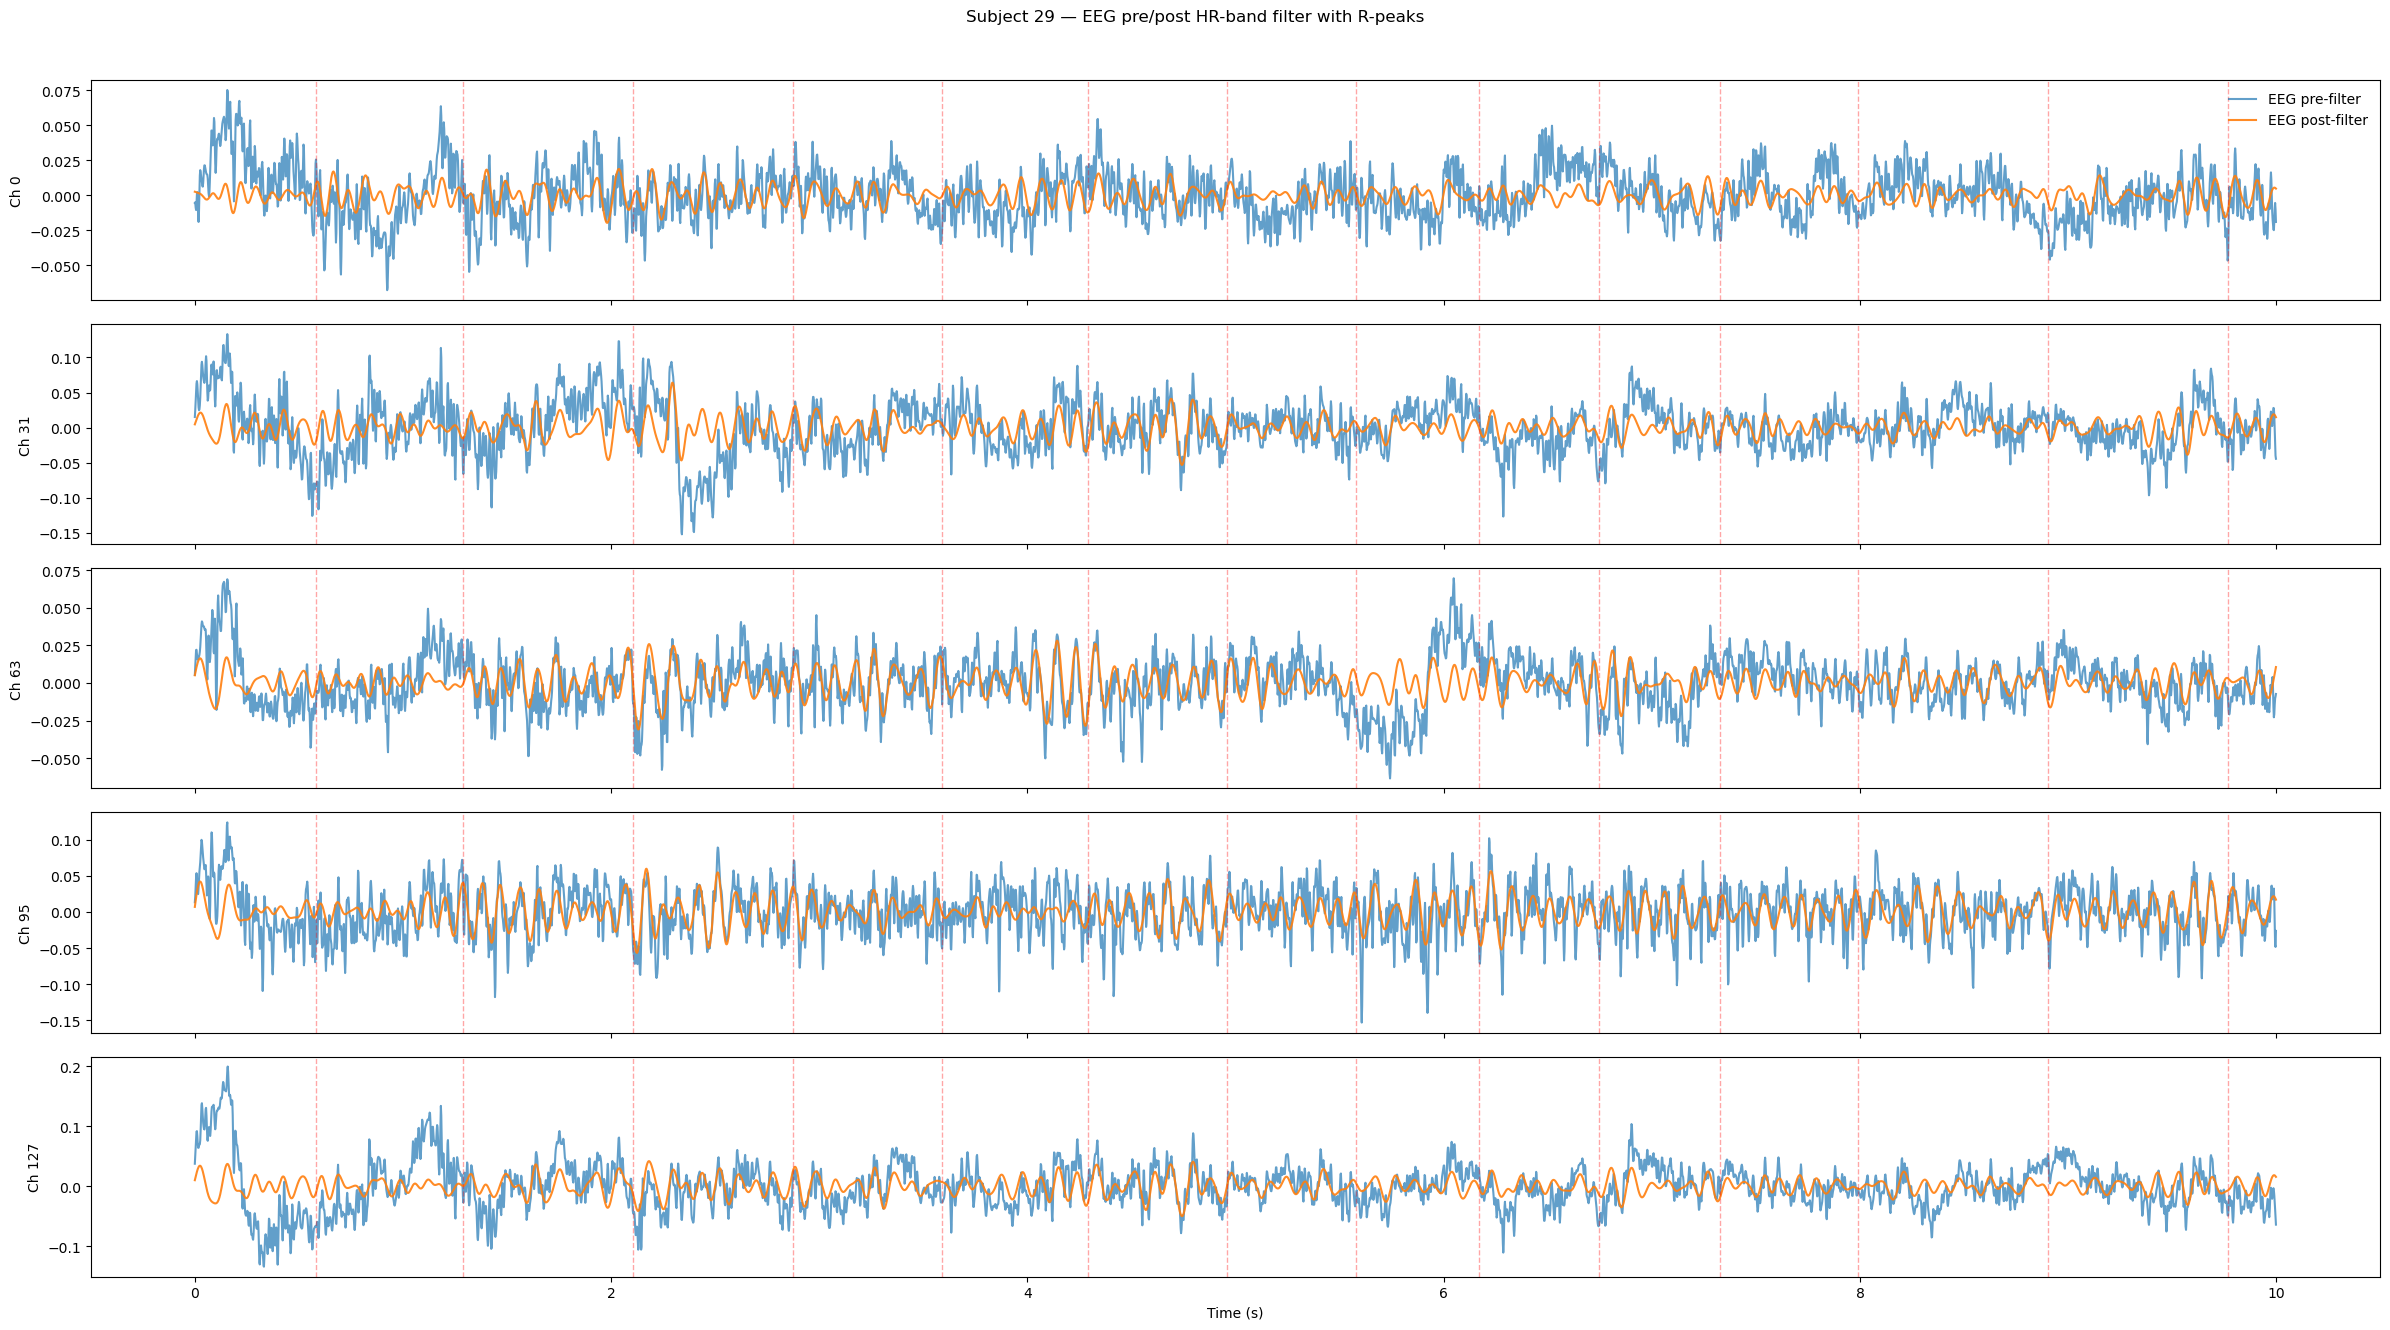

In [5]:
# EEG pre/post-filter visualization with R-peaks (5 channels) + residual and metrics
plot_subj = test_subj  # subject to visualize

pre_ds = data_preprocessed[plot_subj].get('EEG_unfilt', None)
post_ds = data_preprocessed[plot_subj]['EEG']
fs_ds = data_preprocessed[plot_subj]['freq']
rpeaks_ds = data_preprocessed[plot_subj]['R_peaks']

# Reconstruct pre-filter downsampled EEG if not present in cache
if pre_ds is None:
    raw = data_parsed[plot_subj]['EEG'].copy()  # (C, T_full)
    raw = minmax_scale(raw, feature_range=(0, 1), axis=1)
    raw = raw - np.mean(raw, axis=1, keepdims=True)
    pre_ds = raw[:, ::tau]

n_channels = pre_ds.shape[0]
n_samp = min(int(duration_sec * fs_ds), pre_ds.shape[1])  # plot up to duration_sec
t = np.arange(pre_ds.shape[1]) / fs_ds

# Select 5 channels evenly across the montage
n_plot = 5
chan_idx = np.linspace(0, n_channels - 1, n_plot, dtype=int)
fig, axes = plt.subplots(n_plot, 1, figsize=(24, 2.6 * n_plot), sharex=True)

for i, ch in enumerate(chan_idx):
    ax = axes[i]
    y0 = pre_ds[ch, :n_samp]
    y1 = post_ds[ch, :n_samp]

    ax.plot(t[:n_samp], y0, label='EEG pre-filter', color='C0', alpha=0.7)
    ax.plot(t[:n_samp], y1, label='EEG post-filter', color='C1', alpha=0.9)

    # R-peak vertical lines (downsampled indices)
    for rp in rpeaks_ds:
        if 0 <= rp < n_samp:
            ax.axvline(t[rp], color='r', linestyle='--', alpha=0.35, linewidth=1)
    ax.set_ylabel(f"Ch {ch}")
    if i == 0:
        ax.legend(loc='upper right', frameon=False)

axes[-1].set_xlabel('Time (s)')
fig.suptitle(f'Subject {plot_subj} — EEG pre/post HR-band filter with R-peaks', y=1.02)
plt.tight_layout()
plt.show()


Aggregate feature: EEG_zero_lag
   1. Ch 55 | median|corr|=0.0244
   2. Ch 44 | median|corr|=0.0231
   3. Ch 78 | median|corr|=0.0205
   4. Ch 48 | median|corr|=0.0201
   5. Ch 12 | median|corr|=0.0191
   6. Ch 43 | median|corr|=0.0183
   7. Ch 85 | median|corr|=0.0183
   8. Ch 97 | median|corr|=0.0182
   9. Ch 92 | median|corr|=0.0179
  10. Ch 21 | median|corr|=0.0176


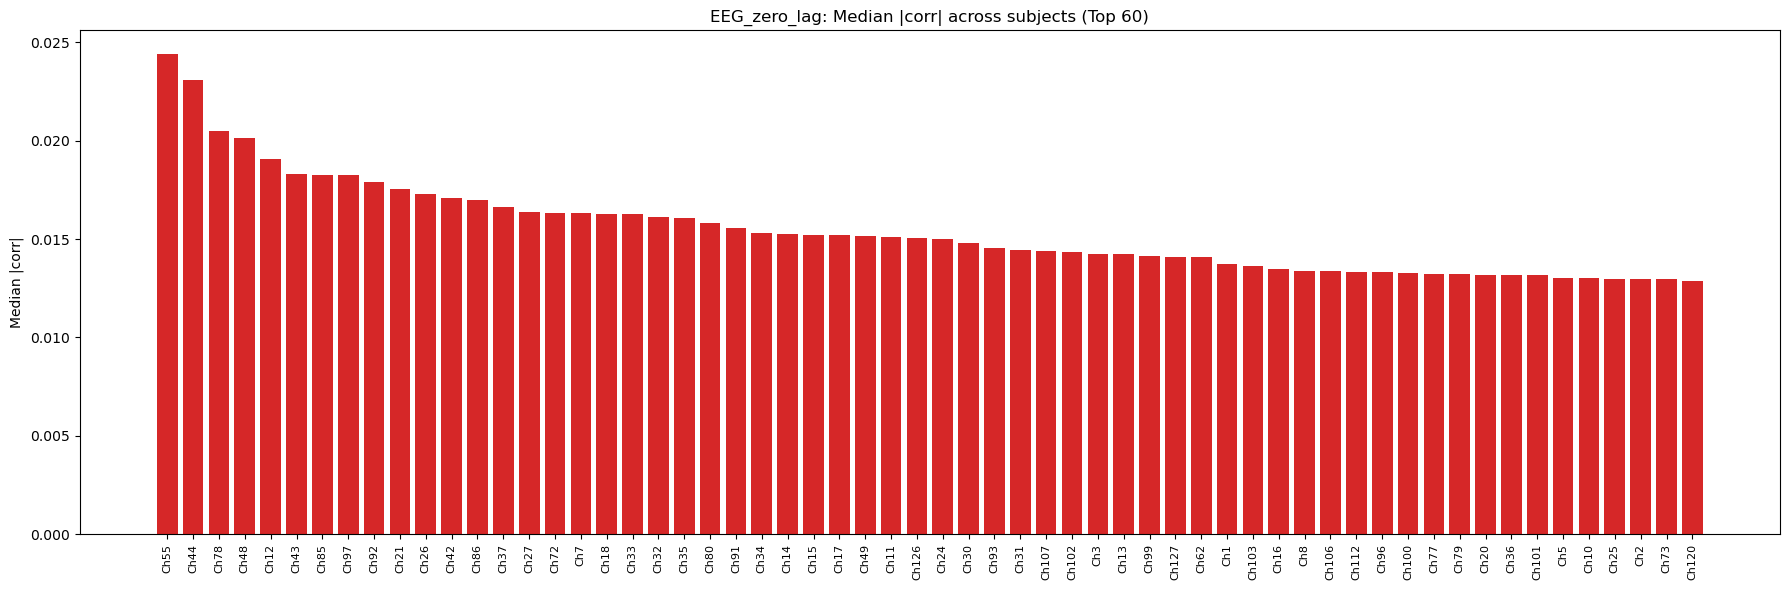

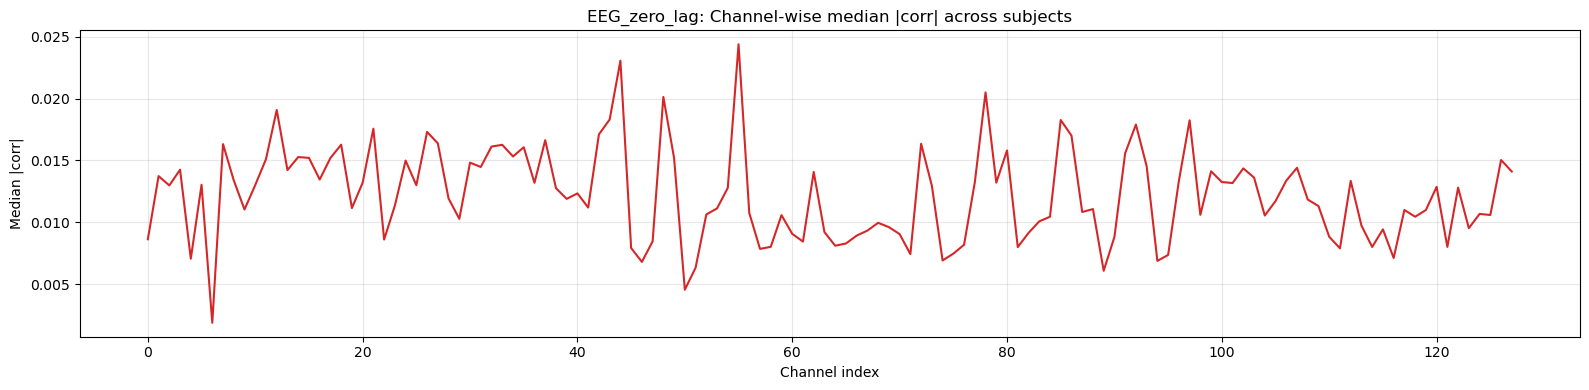

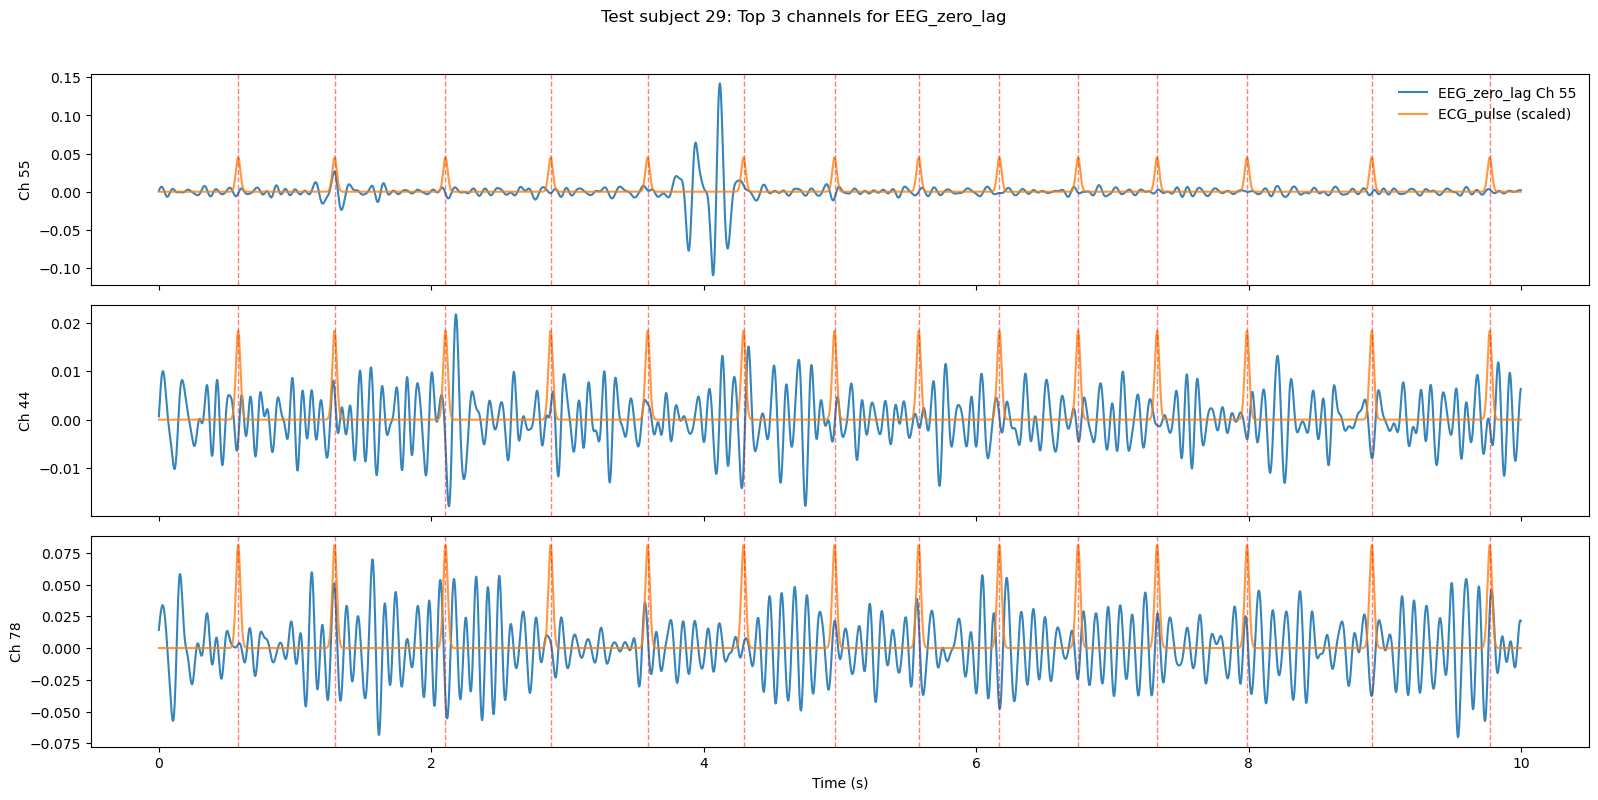


Aggregate feature: Energy(squared)
   1. Ch 123 | median|corr|=0.0239
   2. Ch 27 | median|corr|=0.0226
   3. Ch 15 | median|corr|=0.0224
   4. Ch 47 | median|corr|=0.0222
   5. Ch 03 | median|corr|=0.0221
   6. Ch 116 | median|corr|=0.0220
   7. Ch 17 | median|corr|=0.0212
   8. Ch 115 | median|corr|=0.0212
   9. Ch 32 | median|corr|=0.0210
  10. Ch 06 | median|corr|=0.0210


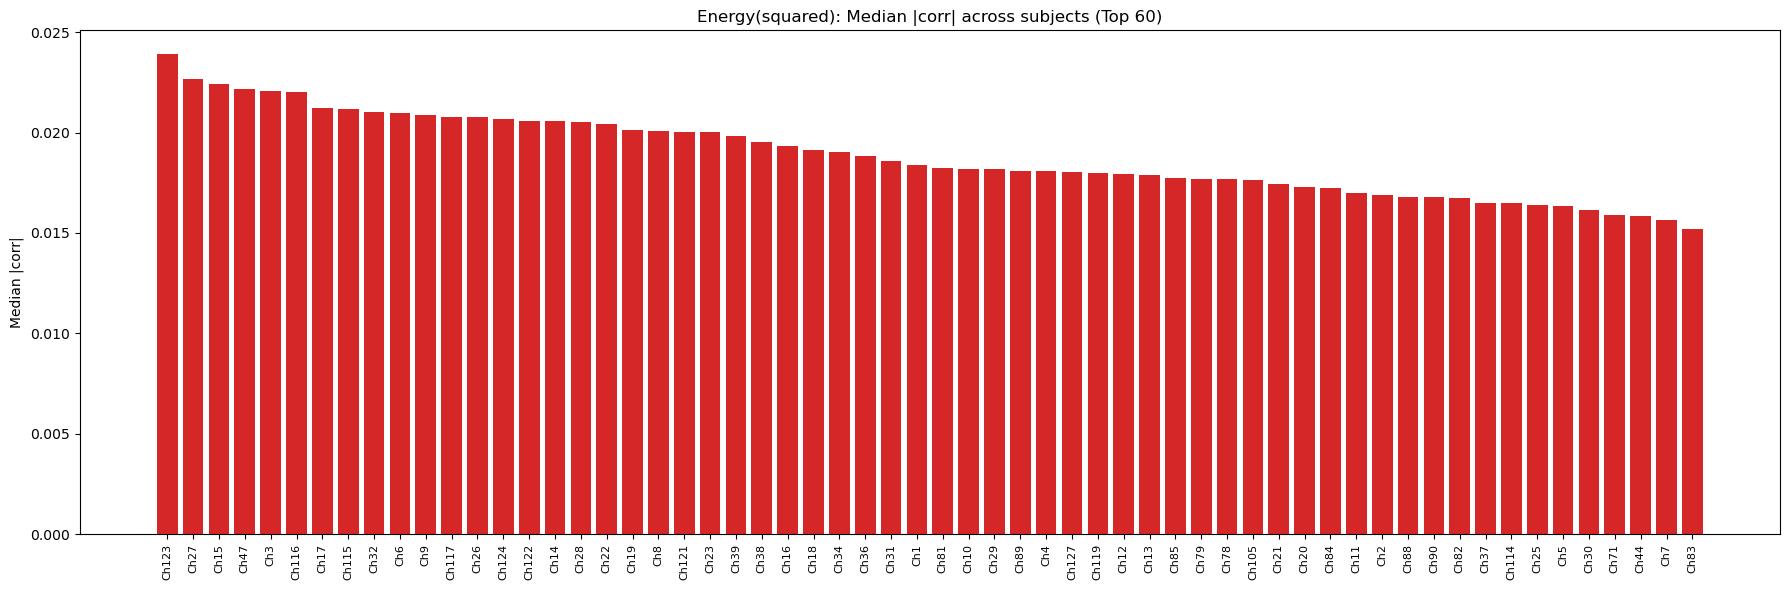

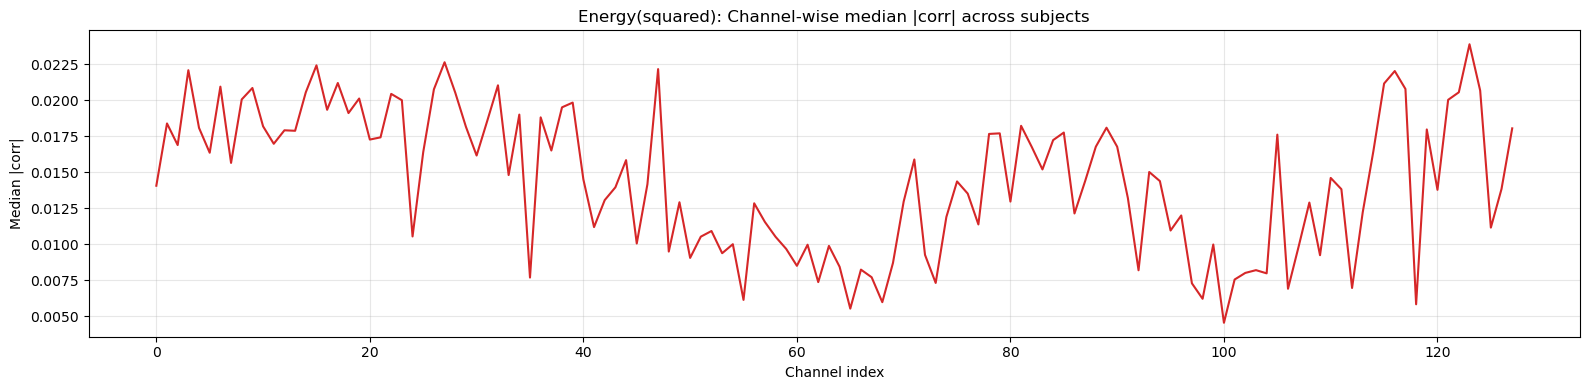

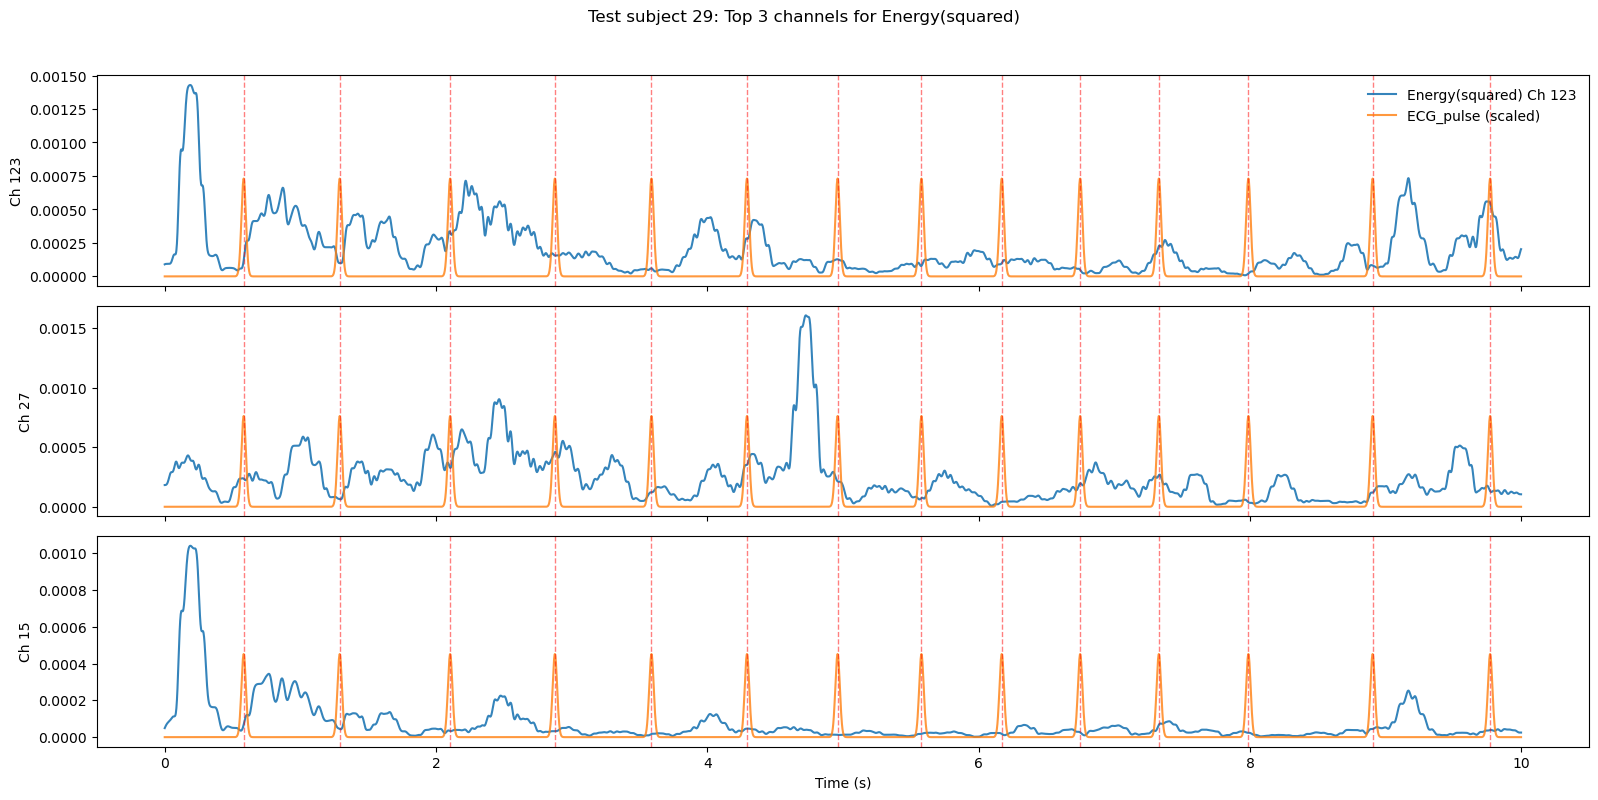


Aggregate feature: Op:hilbert_env
   1. Ch 123 | median|corr|=0.0261
   2. Ch 122 | median|corr|=0.0236
   3. Ch 03 | median|corr|=0.0227
   4. Ch 16 | median|corr|=0.0225
   5. Ch 15 | median|corr|=0.0222
   6. Ch 08 | median|corr|=0.0218
   7. Ch 127 | median|corr|=0.0217
   8. Ch 27 | median|corr|=0.0213
   9. Ch 43 | median|corr|=0.0207
  10. Ch 121 | median|corr|=0.0204


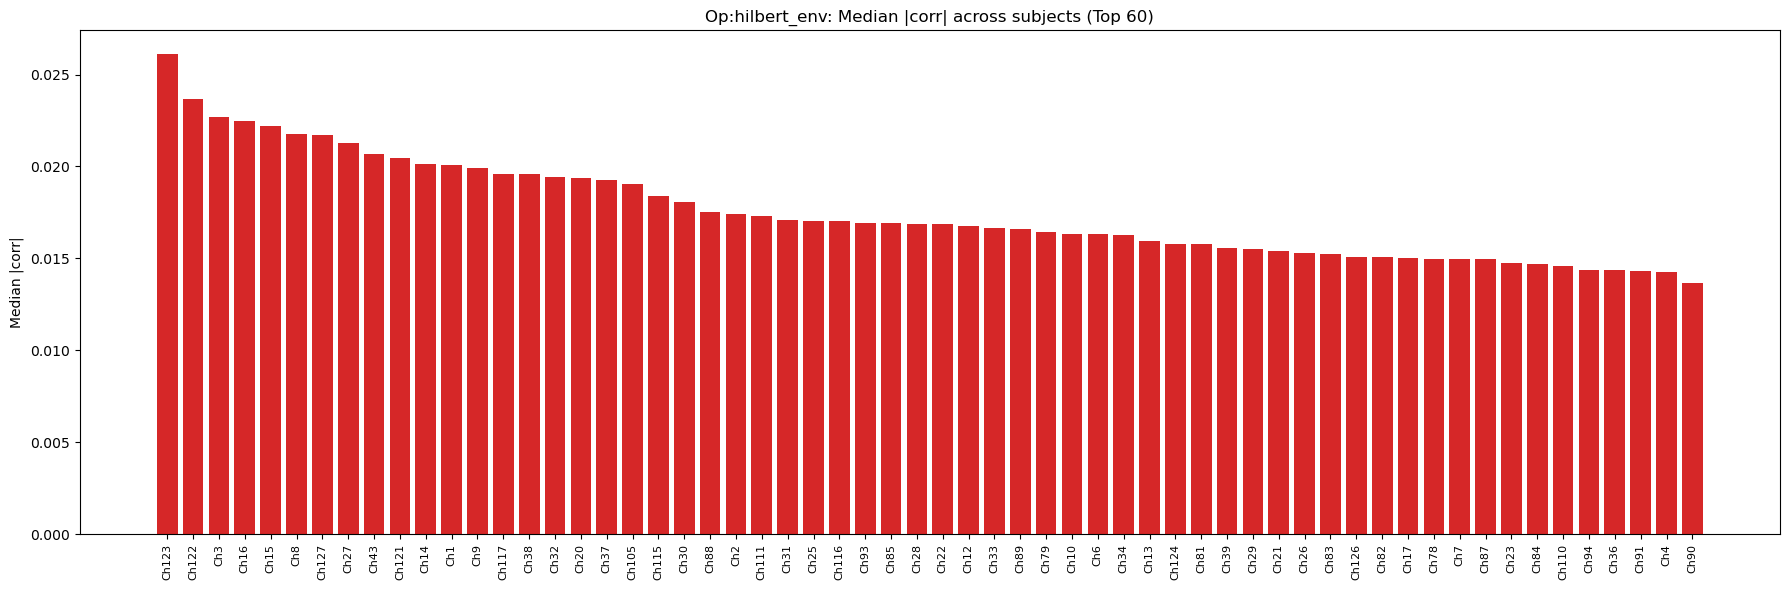

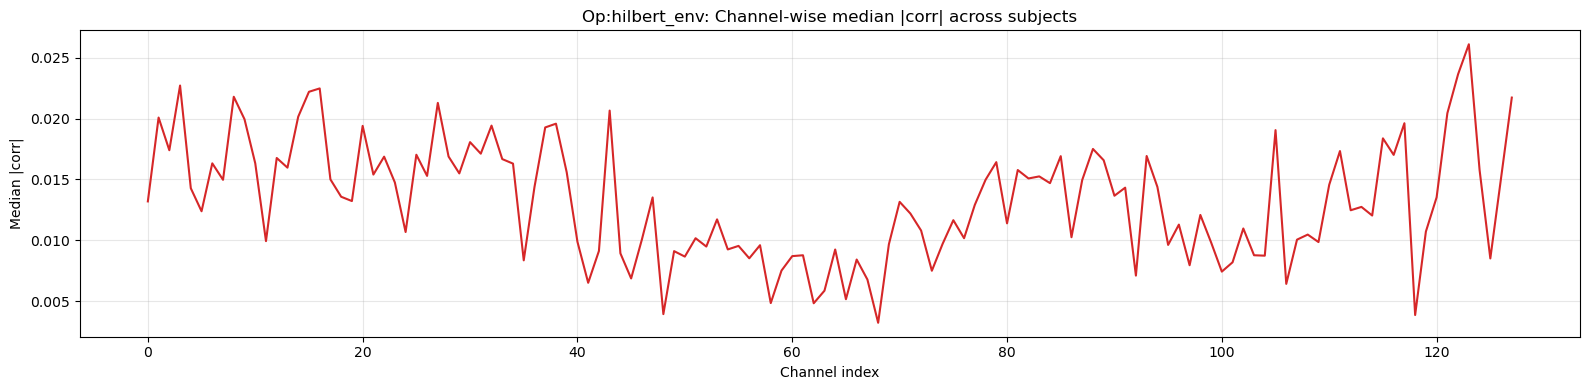

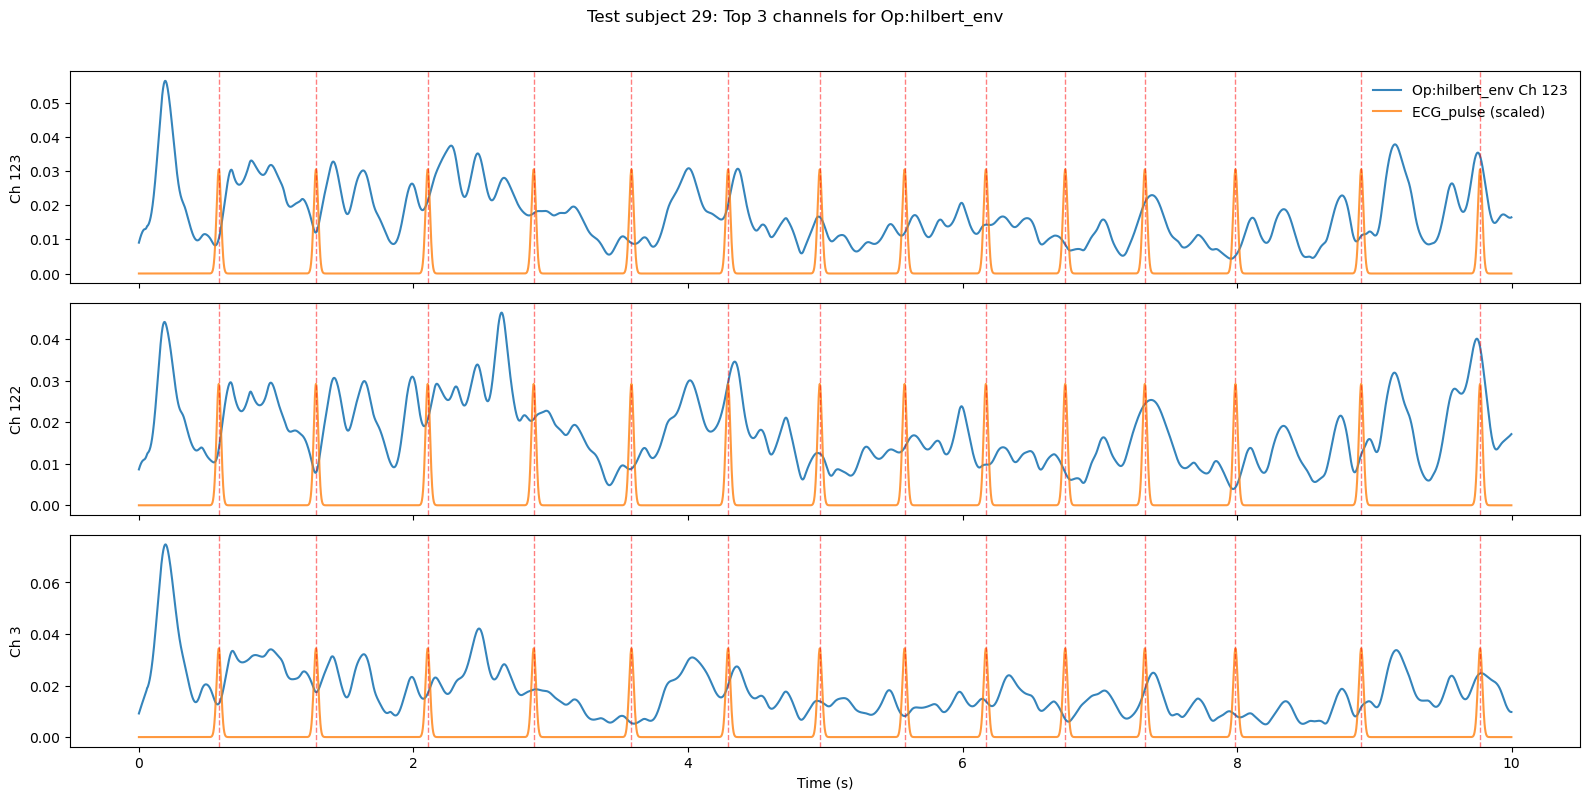


Aggregate feature: Op:shannon
   1. Ch 123 | median|corr|=0.0250
   2. Ch 27 | median|corr|=0.0228
   3. Ch 16 | median|corr|=0.0227
   4. Ch 15 | median|corr|=0.0225
   5. Ch 03 | median|corr|=0.0219
   6. Ch 122 | median|corr|=0.0216
   7. Ch 08 | median|corr|=0.0215
   8. Ch 32 | median|corr|=0.0214
   9. Ch 14 | median|corr|=0.0209
  10. Ch 09 | median|corr|=0.0209


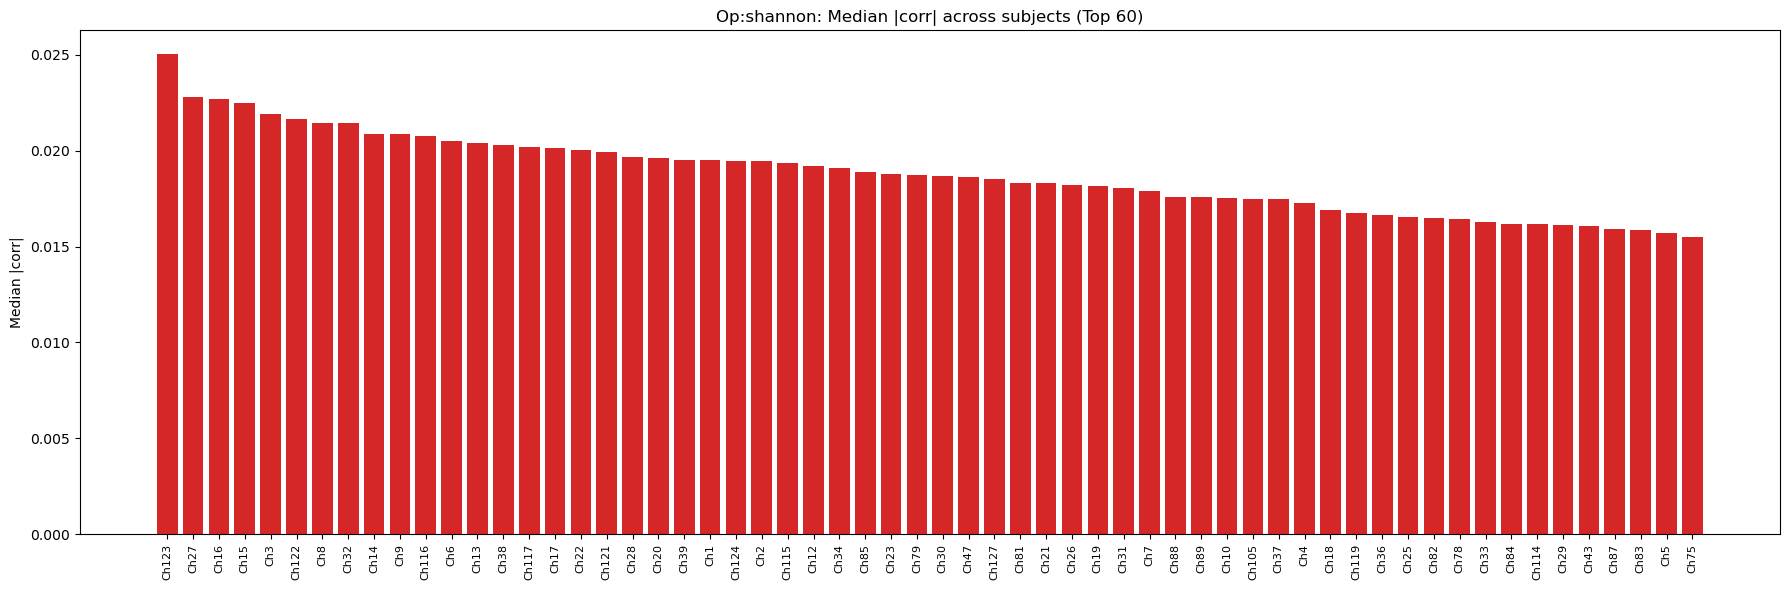

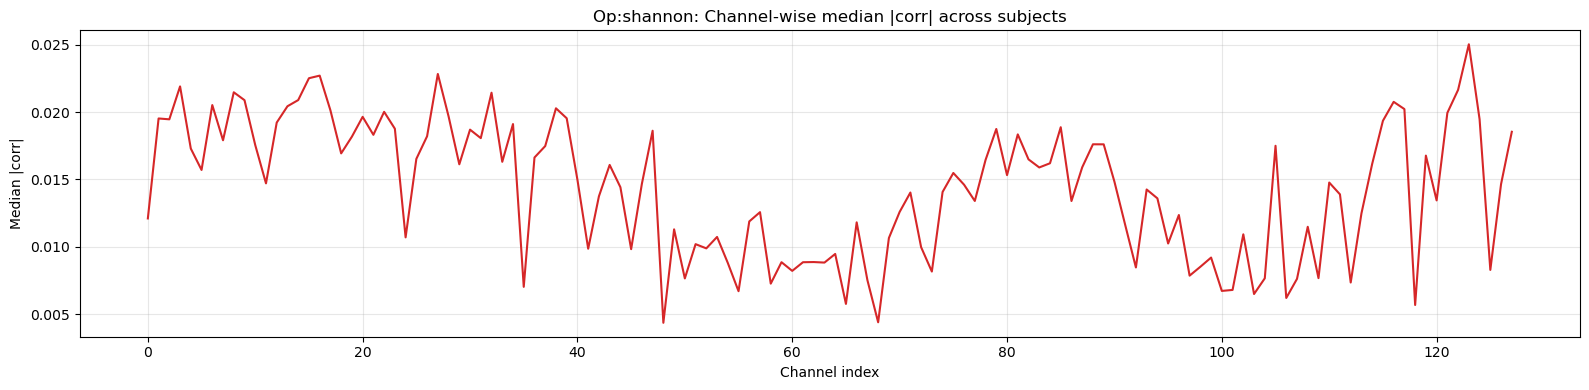

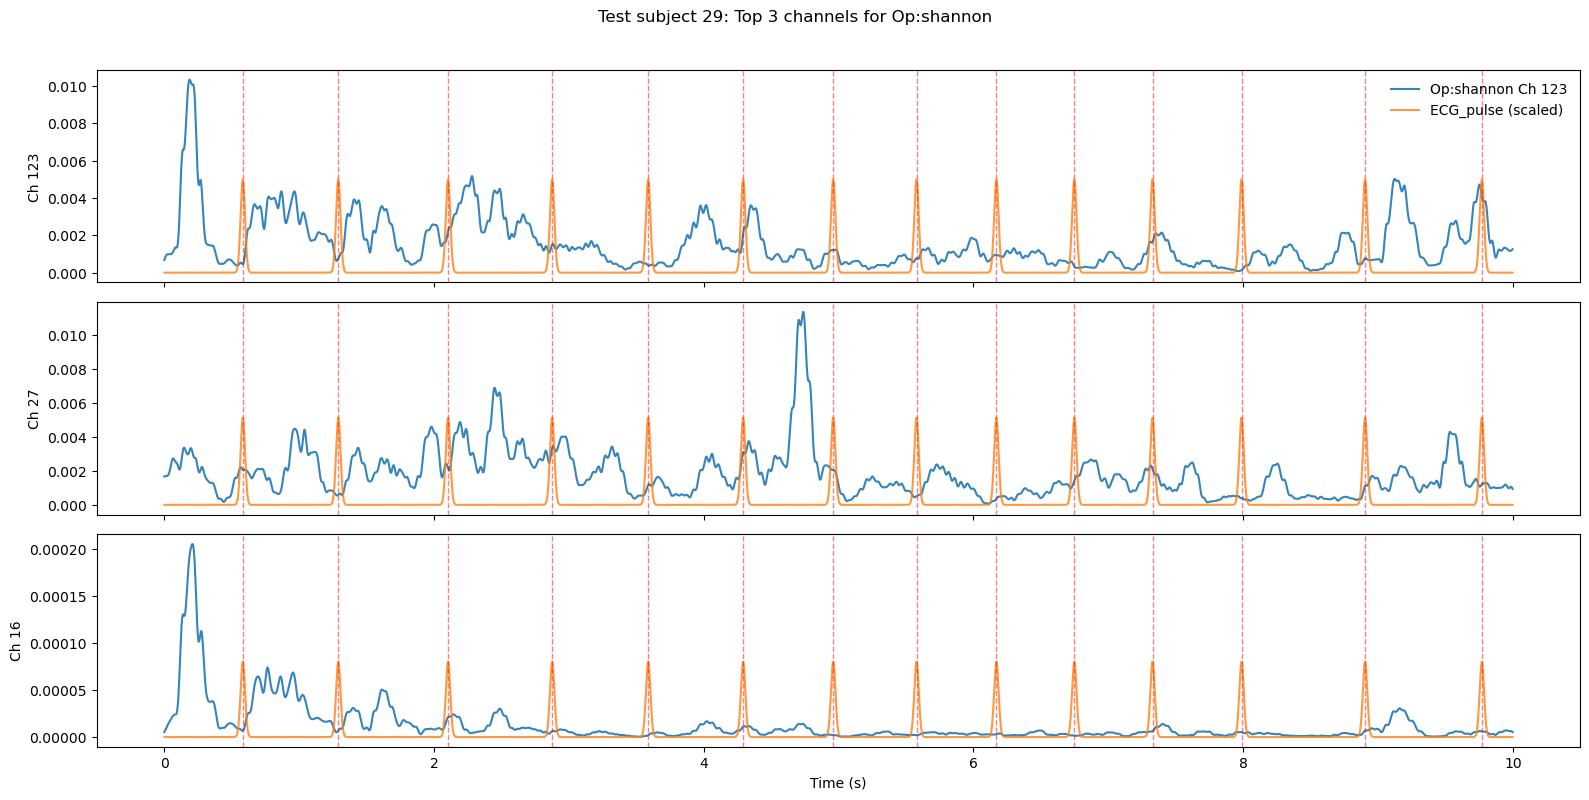


Aggregate feature: Op:ssf
   1. Ch 124 | median|corr|=0.0251
   2. Ch 121 | median|corr|=0.0241
   3. Ch 127 | median|corr|=0.0237
   4. Ch 115 | median|corr|=0.0227
   5. Ch 14 | median|corr|=0.0212
   6. Ch 114 | median|corr|=0.0208
   7. Ch 123 | median|corr|=0.0207
   8. Ch 122 | median|corr|=0.0202
   9. Ch 47 | median|corr|=0.0201
  10. Ch 116 | median|corr|=0.0201


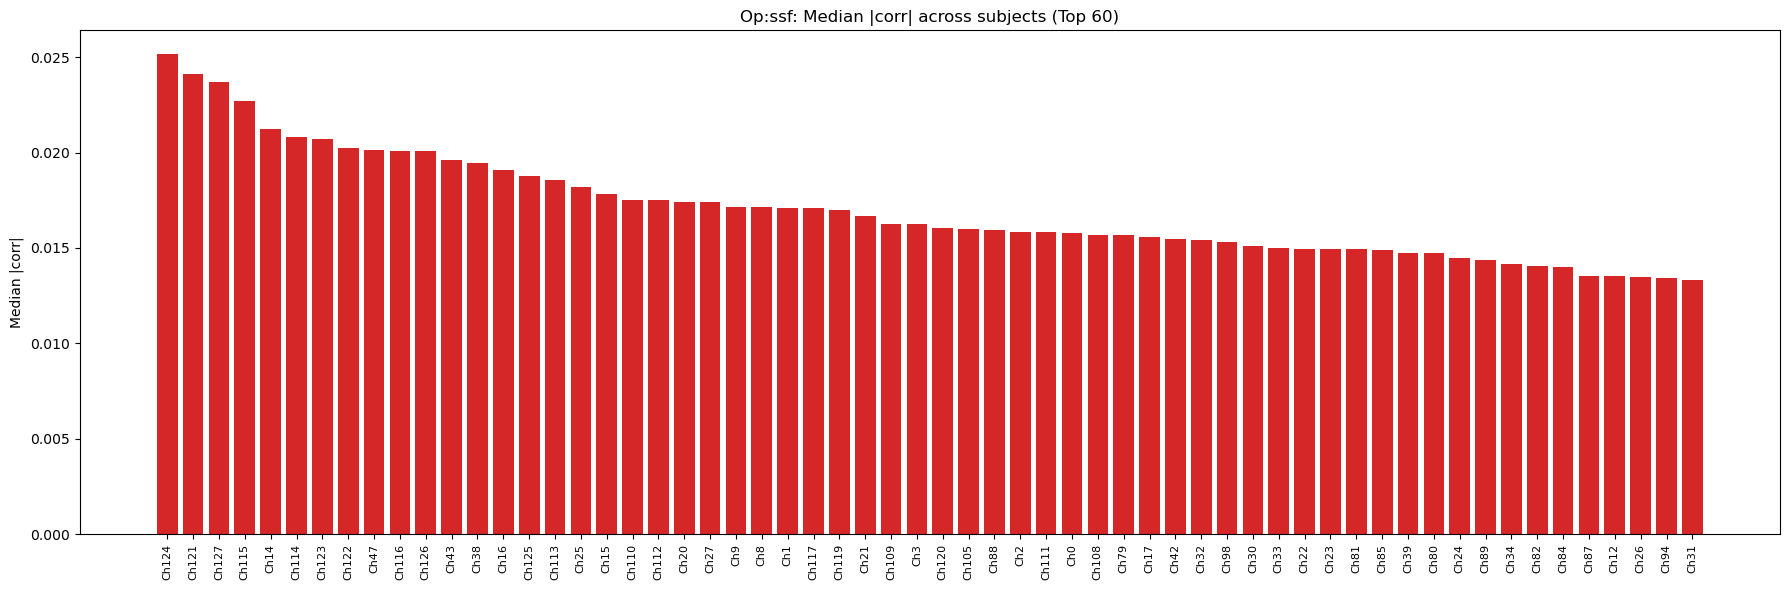

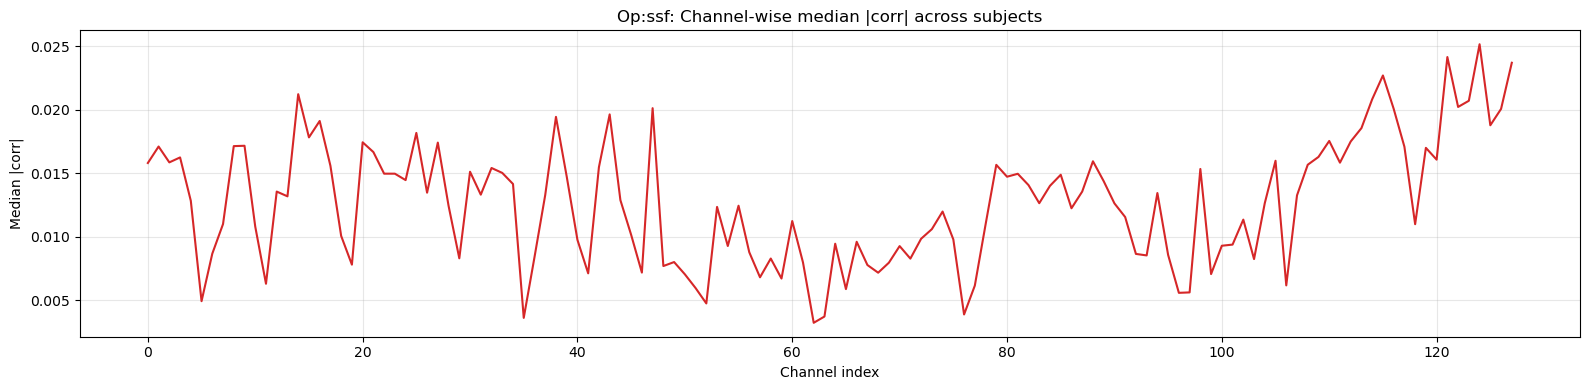

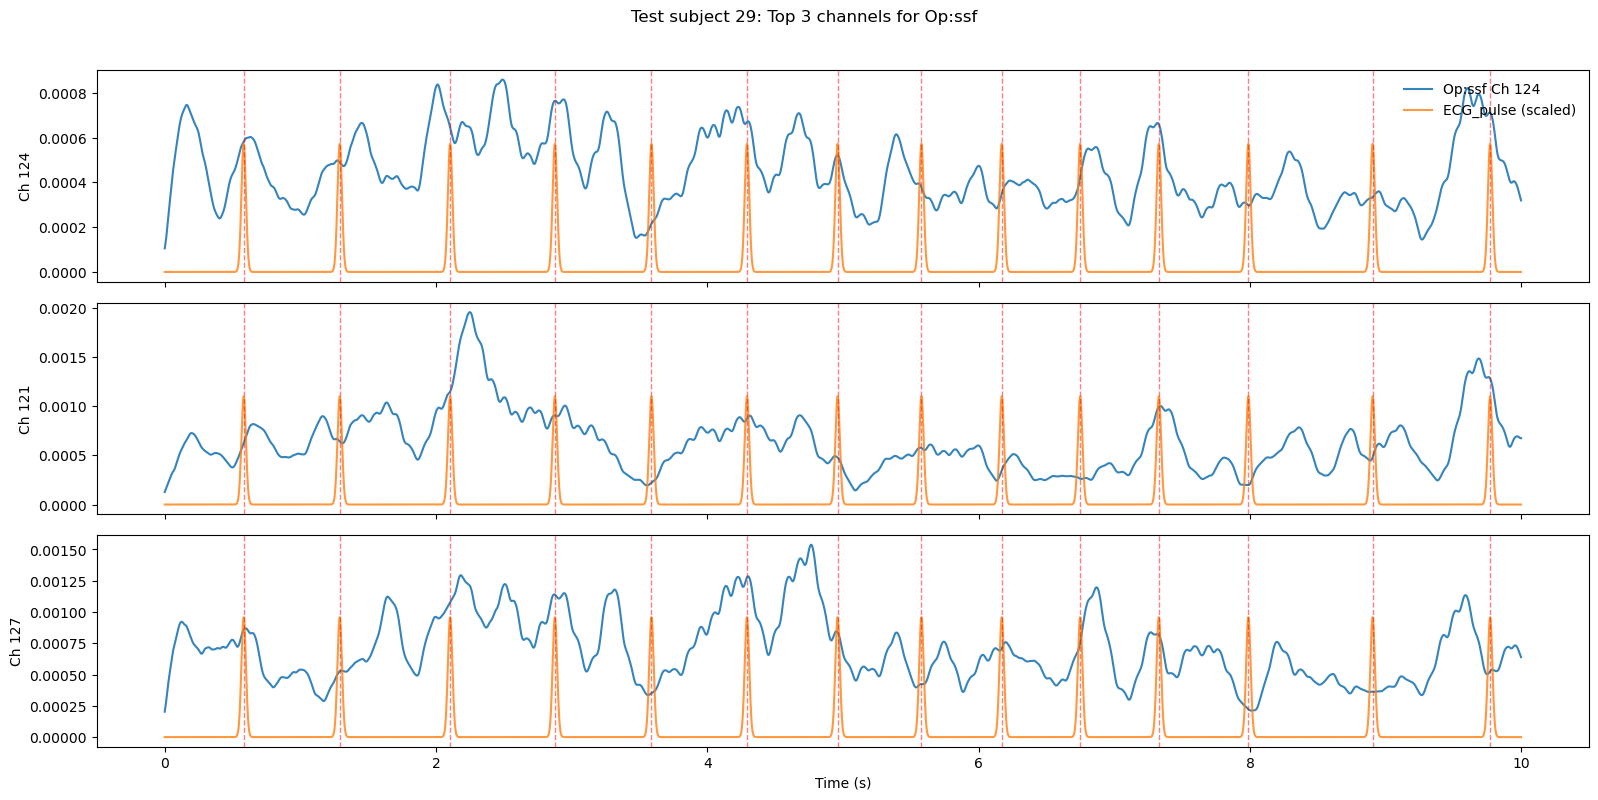


Aggregate feature: Op:mwi
   1. Ch 115 | median|corr|=0.0252
   2. Ch 121 | median|corr|=0.0244
   3. Ch 47 | median|corr|=0.0243
   4. Ch 124 | median|corr|=0.0234
   5. Ch 122 | median|corr|=0.0232
   6. Ch 123 | median|corr|=0.0229
   7. Ch 01 | median|corr|=0.0227
   8. Ch 114 | median|corr|=0.0226
   9. Ch 16 | median|corr|=0.0223
  10. Ch 116 | median|corr|=0.0219


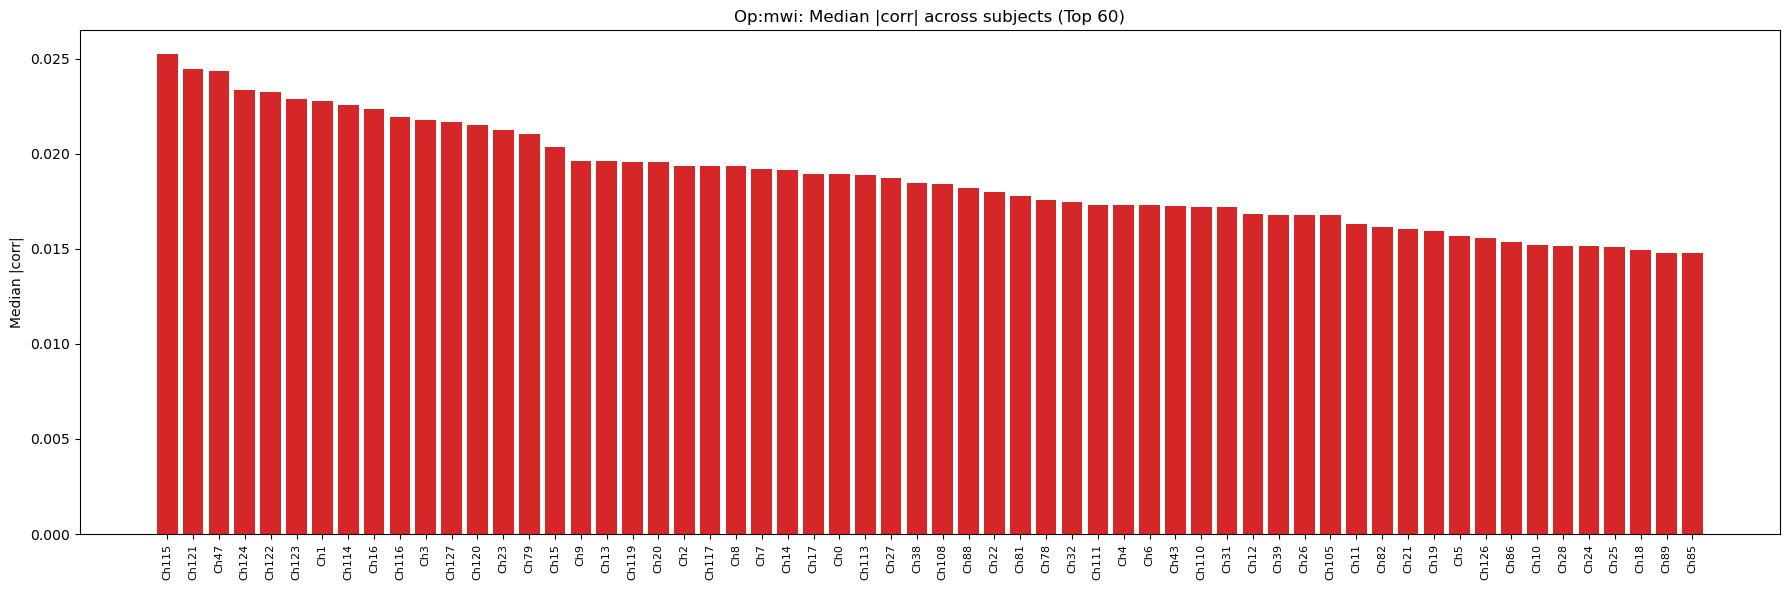

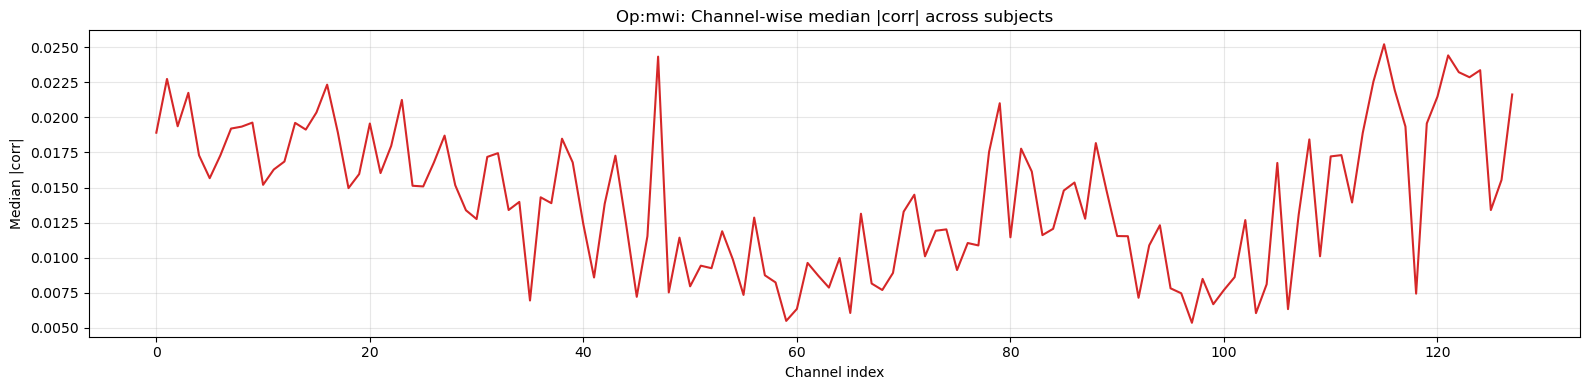

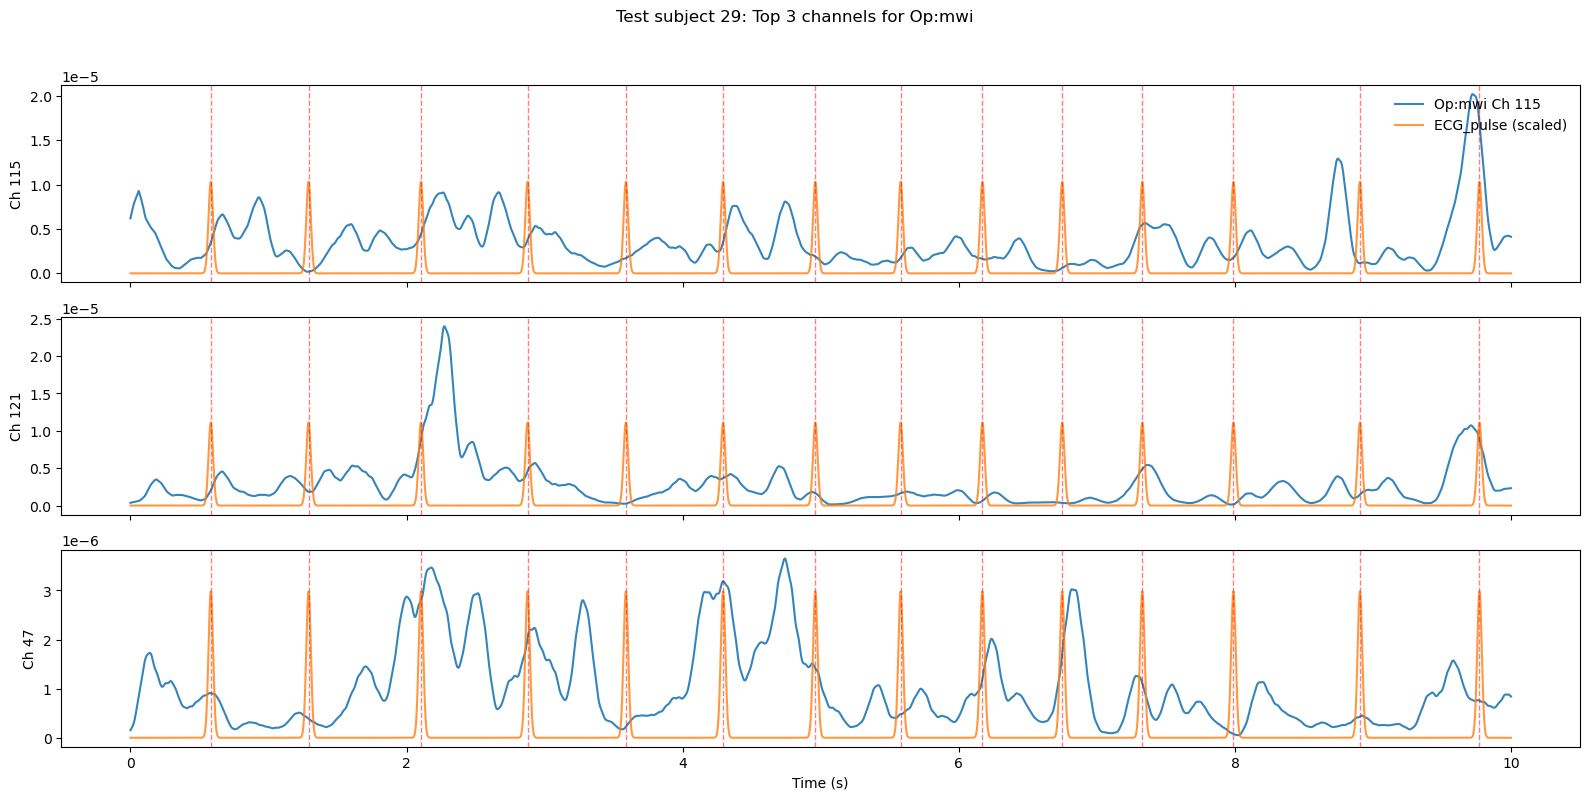


Aggregate feature: Op:tkeo
   1. Ch 115 | median|corr|=0.0246
   2. Ch 16 | median|corr|=0.0243
   3. Ch 47 | median|corr|=0.0242
   4. Ch 122 | median|corr|=0.0240
   5. Ch 123 | median|corr|=0.0238
   6. Ch 01 | median|corr|=0.0231
   7. Ch 121 | median|corr|=0.0230
   8. Ch 124 | median|corr|=0.0230
   9. Ch 116 | median|corr|=0.0227
  10. Ch 79 | median|corr|=0.0226


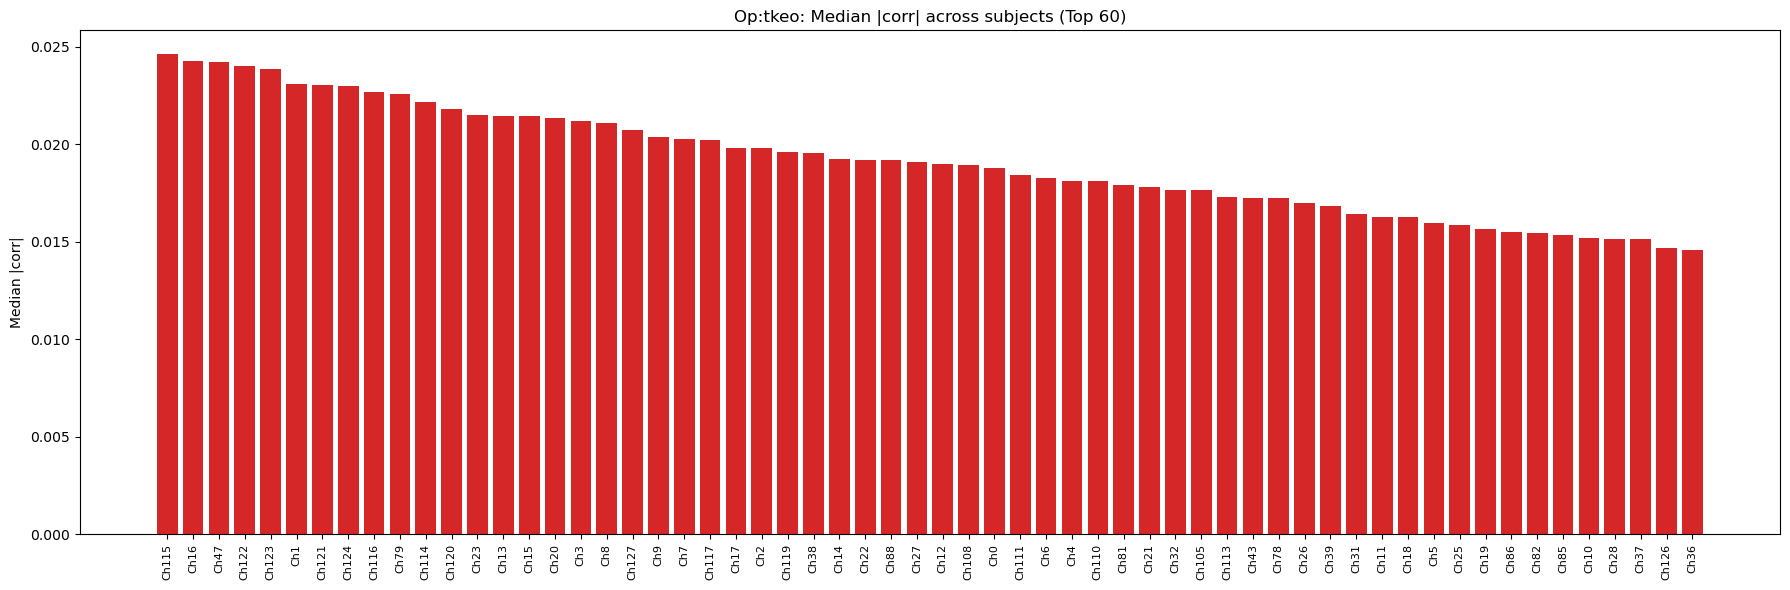

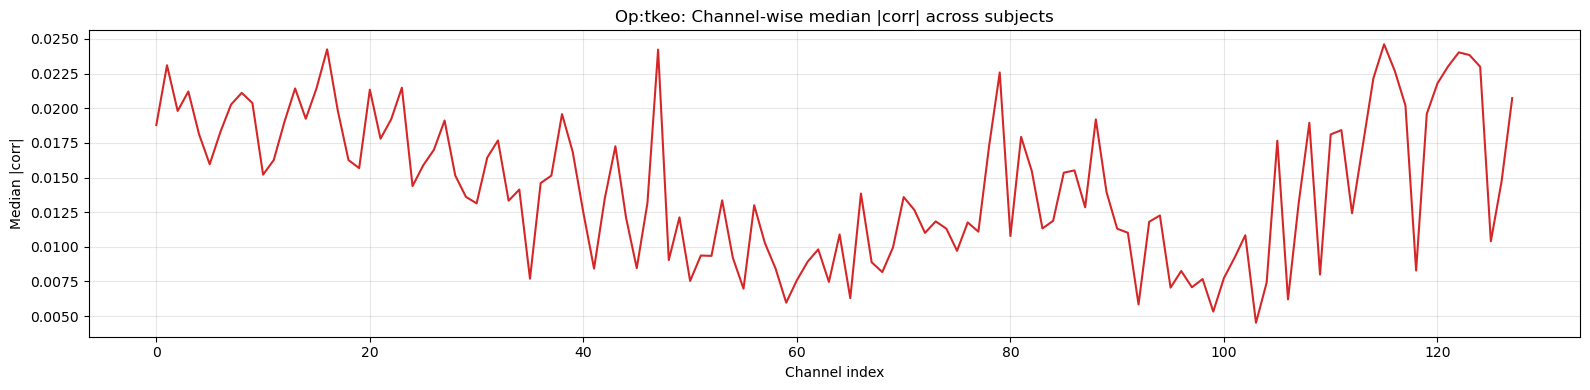

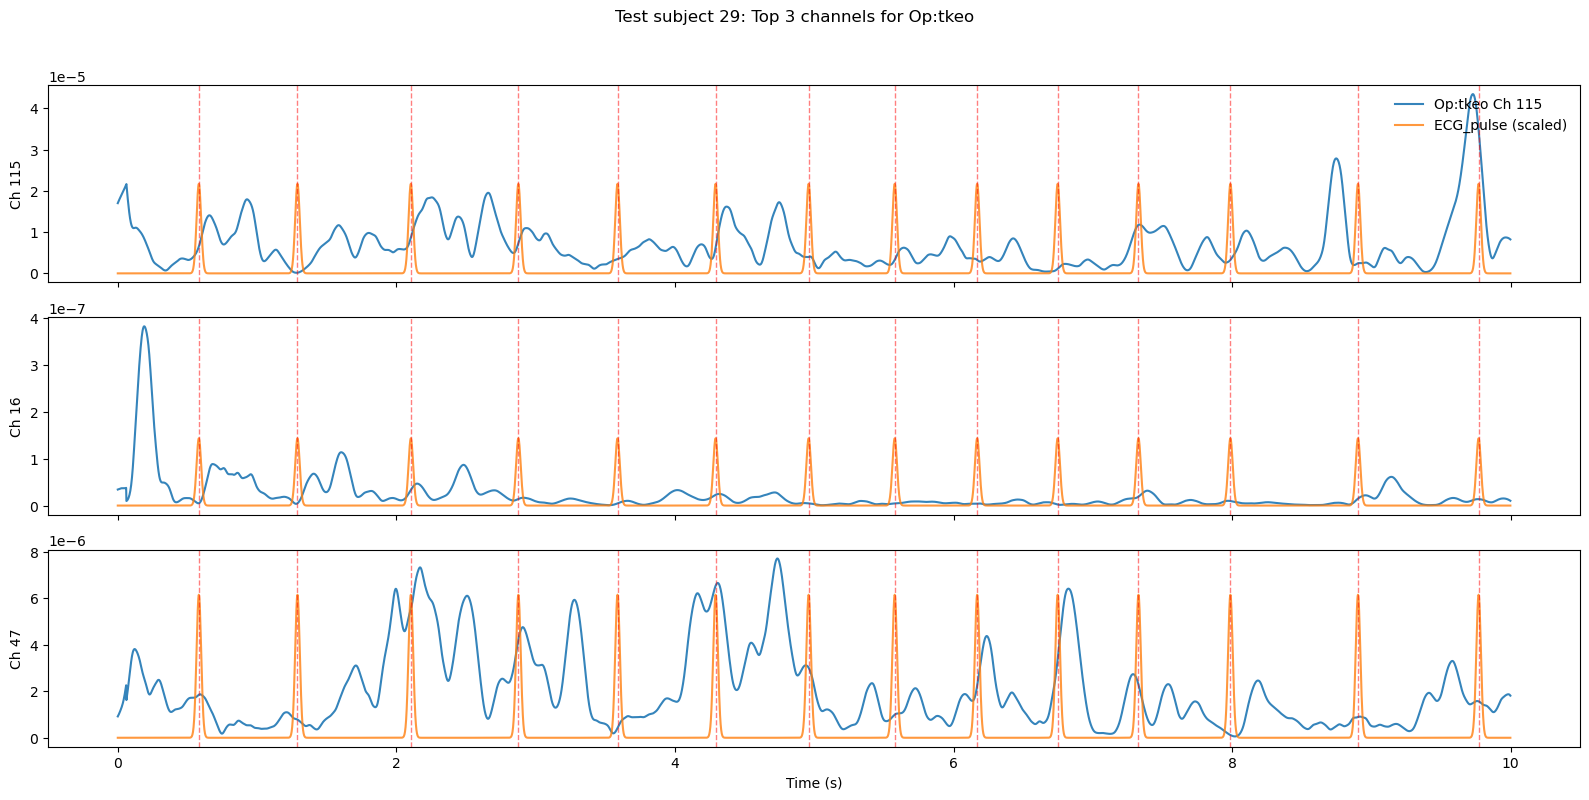


Aggregate feature: Op:squared
   1. Ch 123 | median|corr|=0.0246
   2. Ch 27 | median|corr|=0.0226
   3. Ch 15 | median|corr|=0.0219
   4. Ch 47 | median|corr|=0.0218
   5. Ch 16 | median|corr|=0.0218
   6. Ch 08 | median|corr|=0.0216
   7. Ch 32 | median|corr|=0.0216
   8. Ch 06 | median|corr|=0.0213
   9. Ch 03 | median|corr|=0.0211
  10. Ch 122 | median|corr|=0.0208


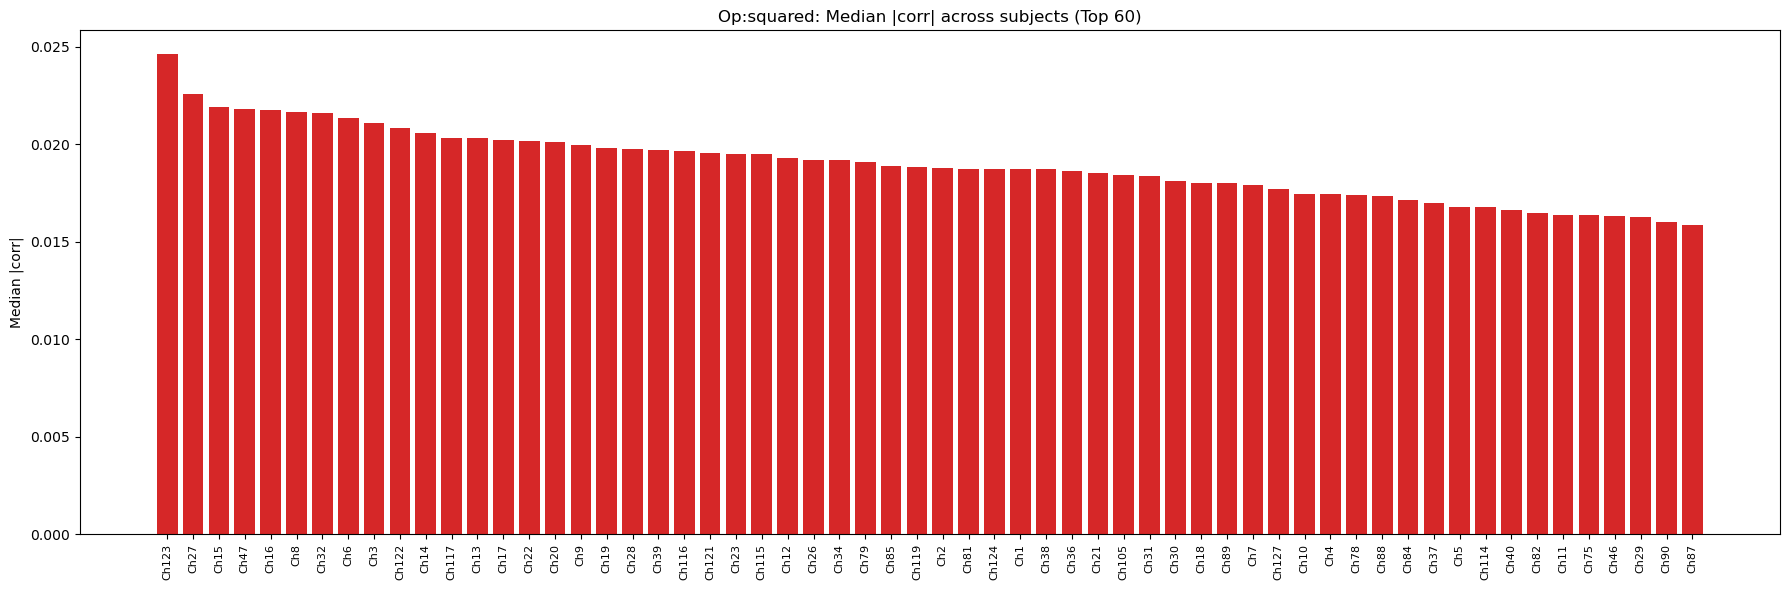

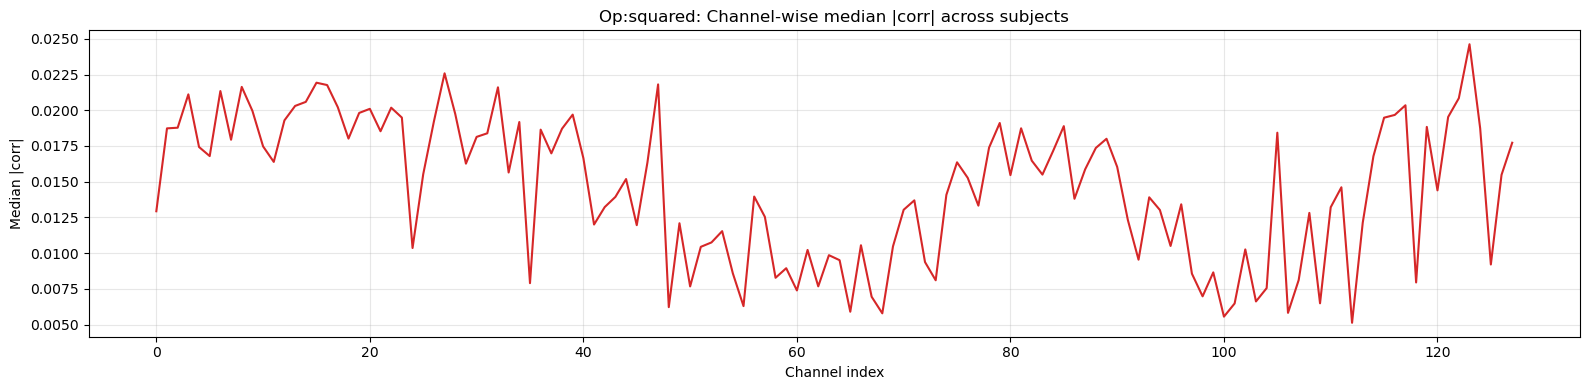

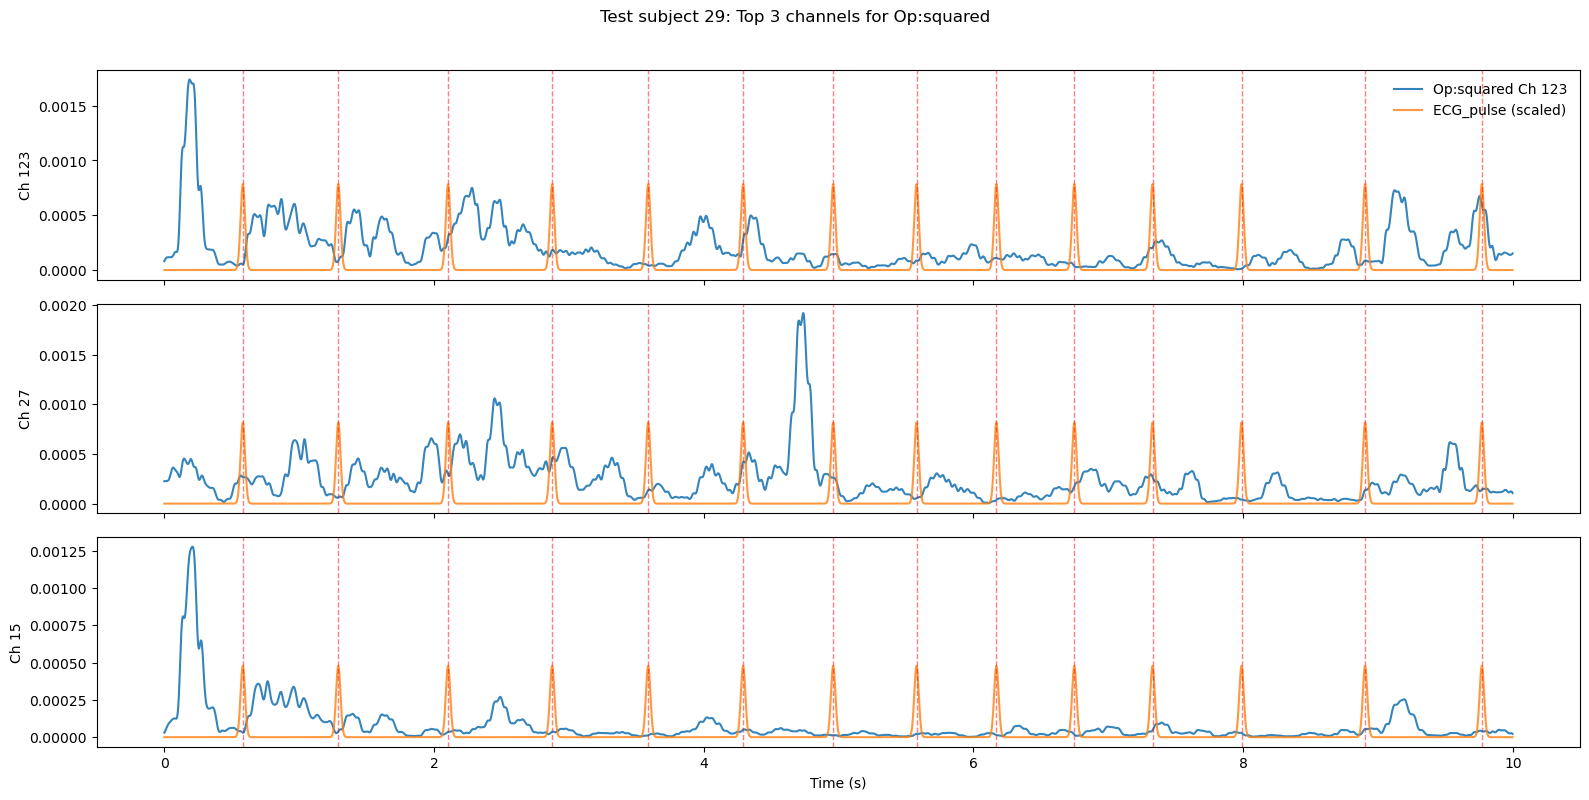

In [6]:
# Aggregate feature correlations across subjects (median-only) + inline test-subject example
import numpy as np, matplotlib.pyplot as plt
from scipy.signal import hilbert

# Parameters
top_k_plot_bars = 60
top_k_timeplot = 3

energy_method = 'squared'       # 'squared' or 'tkeo'
energy_smooth_win_s = 0.15

ops_to_eval = ['hilbert_env', 'shannon', 'ssf', 'mwi', 'tkeo', 'squared']
op_smooth_win_s = 0.12
ssf_win_s = 0.15
mwi_win_s = 0.08

subj_to_plot = test_subj

def zscore_channels(X):
    return (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)

def moving_avg(x, w):
    if w <= 1: return x
    return np.convolve(x, np.ones(w)/w, mode='same')

def feat_energy(x, fs, method='squared', smooth_win_s=0.15):
    w = max(1, int(round(smooth_win_s * fs)))
    C, T = x.shape
    out = np.zeros_like(x)
    for ch in range(C):
        sig = x[ch]
        if method == 'tkeo':
            if sig.size < 3:
                e = sig*sig
            else:
                e = np.empty_like(sig); e[0]=sig[0]**2; e[-1]=sig[-1]**2; e[1:-1]=sig[1:-1]**2 - sig[:-2]*sig[2:]; e = np.maximum(e,0)
        else:
            e = sig*sig
        out[ch] = moving_avg(e, w)
    return out

def op_squared(x): return x*x
def op_tkeo(x):
    if x.size < 3: return x*x
    y = np.empty_like(x); y[0]=x[0]**2; y[-1]=x[-1]**2; y[1:-1]=x[1:-1]**2 - x[:-2]*x[2:]; return np.maximum(y,0)
def op_hilbert_env(x): return np.abs(hilbert(x))
def op_shannon(x, eps=1e-8):
    e = x*x; return -e * np.log(e + eps)
def op_ssf(x, win):
    d = np.diff(x, prepend=x[0]); d_pos = np.maximum(d,0); return moving_avg(d_pos, win)
def op_mwi(x, win):
    d = np.diff(x, prepend=x[0]); y = d*d; return moving_avg(y, win)

def build_operator_features(EEG, fs):
    w_smooth = max(1, int(round(op_smooth_win_s * fs)))
    w_ssf = max(1, int(round(ssf_win_s * fs)))
    w_mwi = max(1, int(round(mwi_win_s * fs)))
    op_funcs = {
        'squared': lambda x: op_squared(x),
        'tkeo': lambda x: op_tkeo(x),
        'hilbert_env': lambda x: op_hilbert_env(x),
        'shannon': lambda x: op_shannon(x),
        'ssf': lambda x: op_ssf(x, w_ssf),
        'mwi': lambda x: op_mwi(x, w_mwi)
    }
    feats = {}
    C, T = EEG.shape
    for name in ops_to_eval:
        arr = np.zeros((C, T), dtype=float)
        f = op_funcs[name]
        for ch in range(C):
            y = f(EEG[ch])
            arr[ch] = moving_avg(y, w_smooth)  # light smoothing
        feats[name] = arr
    return feats

def channel_corr(feat_z, pulse_z):
    C = feat_z.shape[0]
    corr = np.empty(C, dtype=float)
    for ch in range(C):
        corr[ch] = np.corrcoef(feat_z[ch], pulse_z)[0,1]
    return corr

# Common channel count to ensure stacking across subjects
C_common = min(data_preprocessed[ss]['EEG'].shape[0] for ss in subj_all)

# Aggregate correlations per feature across subjects
agg_corr = {'EEG_zero_lag': []}
energy_name = f"Energy({energy_method})"

for ss in subj_all:
    fs_ds = int(data_preprocessed[ss]['freq'])
    EEG_ss = data_preprocessed[ss]['EEG'][:C_common]
    pulse_ss = data_preprocessed[ss]['ECG_pulse']
    L = min(EEG_ss.shape[1], pulse_ss.shape[0])
    X = EEG_ss[:, :L]
    y = pulse_ss[:L]
    y_z = (y - y.mean())/(y.std()+1e-8)

    # Zero-lag EEG
    X_z = zscore_channels(X)
    agg_corr['EEG_zero_lag'].append(channel_corr(X_z, y_z))

    # Energy
    en = feat_energy(X, fs_ds, method=energy_method, smooth_win_s=energy_smooth_win_s)
    en_z = zscore_channels(en)
    agg_corr.setdefault(energy_name, []).append(channel_corr(en_z, y_z))

    # Operators
    op_feats = build_operator_features(X, fs_ds)
    for name, arr in op_feats.items():
        feat_z = zscore_channels(arr)
        agg_corr.setdefault(f"Op:{name}", []).append(channel_corr(feat_z, y_z))

# Median absolute correlations across subjects
median_abs = {k: np.median(np.abs(np.stack(v, axis=0)), axis=0) for k, v in agg_corr.items()}

# Subject-specific features (used inline under each correlation plot)
fs_ds = int(data_preprocessed[subj_to_plot]['freq'])
EEG_t = data_preprocessed[subj_to_plot]['EEG'][:C_common]
pulse_t = data_preprocessed[subj_to_plot]['ECG_pulse']
rpeaks_t = np.asarray(data_preprocessed[subj_to_plot]['R_peaks'], dtype=int)
L = min(EEG_t.shape[1], pulse_t.shape[0])
EEG_t = EEG_t[:, :L]; pulse_t = pulse_t[:L]
en_subj = feat_energy(EEG_t, fs_ds, method=energy_method, smooth_win_s=energy_smooth_win_s)
op_feats_subj = build_operator_features(EEG_t, fs_ds)

feature_arrays = { 'EEG_zero_lag': EEG_t, energy_name: en_subj }
for opn, arr in op_feats_subj.items():
    feature_arrays[f'Op:{opn}'] = arr

# Display and plots (aggregate + inline time-series)
ordered_keys = []
if 'EEG_zero_lag' in median_abs: ordered_keys.append('EEG_zero_lag')
if energy_name in median_abs: ordered_keys.append(energy_name)
for op in ops_to_eval:
    key = f"Op:{op}"
    if key in median_abs: ordered_keys.append(key)

for key in ordered_keys:
    vals = median_abs[key]
    C_all = vals.size
    top_idx = np.argsort(-vals)[:min(top_k_plot_bars, C_all)]
    print(f"\nAggregate feature: {key}")
    for rank, ch in enumerate(top_idx[:min(10, top_idx.size)], 1):
        print(f"  {rank:2d}. Ch {ch:02d} | median|corr|={vals[ch]:.4f}")

    # Bar chart of aggregate top channels (median)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.bar([f"Ch{c}" for c in top_idx], vals[top_idx], color='C3')
    ax.set_title(f"{key}: Median |corr| across subjects (Top {top_idx.size})")
    ax.set_ylabel('Median |corr|')
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    plt.tight_layout(); plt.show()

    # Line plot across all channels (median)
    fig, ax = plt.subplots(figsize=(16,4))
    ax.plot(range(C_all), vals, color='C3')
    ax.set_title(f"{key}: Channel-wise median |corr| across subjects")
    ax.set_xlabel('Channel index'); ax.set_ylabel('Median |corr|'); ax.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    # Inline per-feature time-series plot for test subject (moved from end)
    if key in feature_arrays:
        top_idx_ts = np.argsort(-vals)[:min(top_k_timeplot, vals.size)]
        n_samp = min(int(duration_sec * fs_ds), L)
        t = np.arange(n_samp) / fs_ds
        data_mat = feature_arrays[key]
        fig, axes = plt.subplots(len(top_idx_ts), 1, figsize=(16, 2.6*len(top_idx_ts)), sharex=True)
        if len(top_idx_ts) == 1: axes = [axes]
        for i, ch in enumerate(top_idx_ts):
            ax = axes[i]
            feat_ch = data_mat[ch, :n_samp]
            scale = (np.std(feat_ch) / (np.std(pulse_t[:n_samp]) + 1e-8)) * 0.7
            ax.plot(t, feat_ch, label=f'{key} Ch {ch}', color='C0', alpha=0.9)
            ax.plot(t, pulse_t[:n_samp]*scale, label='ECG_pulse (scaled)', color='C1', alpha=0.8)
            mask = (rpeaks_t >= 0) & (rpeaks_t < n_samp)
            for rp in rpeaks_t[mask]:
                ax.axvline(t[rp], color='r', linestyle='--', alpha=0.5, linewidth=1)
            ax.set_ylabel(f'Ch {ch}')
            if i == 0: ax.legend(loc='upper right', frameon=False)
        axes[-1].set_xlabel('Time (s)')
        plt.suptitle(f'Test subject {subj_to_plot}: Top {len(top_idx_ts)} channels for {key}', y=1.02)
        plt.tight_layout(); plt.show()